In [2]:
from google.colab import drive
drive.mount('/content/drive')
# !pip install category_encoders
# !pip install imblearn
# !pip install xgboost
# !pip install xlearn

Mounted at /content/drive


In [1]:
from cuml.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from cuml.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from cuml.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from cuml.svm import SVC
from sklearn import metrics
from IPython.display import display
from sklearn.metrics import roc_curve, auc
# from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import random
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier
import cupy as cp
from cuml.svm import LinearSVC

In [ ]:
num_records = 40428967
sample_size = 5000000

skip_values = sorted(random.sample(range(1, num_records), num_records - sample_size))

parse_date = lambda val: pd.to_datetime(val, format='%y%m%d%H')

df = pd.read_csv(
    "/kaggle/input/avazu-ctr-prediction/train.gz",
    parse_dates=['hour'],
    date_format='%y%m%d%H',
    skiprows=skip_values
)

df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10005541670676403131,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,20984,320,50,2371,0,551,100217,46
1,10006192453619779489,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,685d1c4c,2347f47a,...,1,3,15708,320,50,1722,0,35,-1,79
2,10006557235872316145,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15699,320,50,1722,0,35,-1,79
3,10007908698866493310,0,2014-10-21,1005,1,0eb72673,d2f72222,f028772b,ecad2386,7801e8d9,...,1,0,16208,320,50,1800,3,167,100075,23
4,10009699694430474960,1,2014-10-21,1005,0,4dd0a958,79cf0c8d,f028772b,ecad2386,7801e8d9,...,1,0,20366,320,50,2333,0,39,-1,157


In [ ]:
df['hour_of_day'] = df['hour'].dt.hour
df['day_of_week'] = df['hour'].dt.dayofweek
df.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,10005541670676403131,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,20984,320,50,2371,0,551,100217,46,0,1
1,10006192453619779489,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,685d1c4c,2347f47a,...,15708,320,50,1722,0,35,-1,79,0,1


In [ ]:
group_data = df[['hour_of_day', 'device_id']].groupby('hour_of_day').count()
df['hourly_user_counts'] = df['hour_of_day'].map(group_data['device_id'])

group_data = df[['day_of_week', 'device_id']].groupby('day_of_week').count()
df['weekly_user_counts'] = df['day_of_week'].map(group_data['device_id'])

In [ ]:
group_data = df[['device_id', 'id']].groupby('device_id').count()
df['device_id_counts'] = df['device_id'].map(group_data['id'])

group_data = df[['device_ip', 'id']].groupby('device_ip').count()
df['device_ip_counts'] = df['device_ip'].map(group_data['id'])

In [ ]:
df['user'] = df['device_id'] + ',' + df['device_model']

In [ ]:
group_data = df[['hour_of_day', 'id']].groupby('hour_of_day').count()
df['hourly_impression_counts'] = df['hour_of_day'].map(group_data['id'])

Như đã phân tích, chúng ta tạo ra một đặc trưng mới cho từng `user` có tên là `frequent_bag_of_app_id`, thể hiện mức độ thường xuyên họ sử dụng các ứng dụng trong dữ liệu. Cụ thể, nó tính tổng số lần mỗi người đã sử dụng các ứng dụng, rồi chia cho tổng số lượng ứng dụng khác nhau trong toàn bộ hệ thống. Kết quả là một con số đại diện cho tần suất trung bình mà người đó tương tác với một ứng dụng, nếu giả định rằng họ phân bổ lượt dùng một cách đều nhau cho tất cả các app. Thông tin này sau đó được gắn vào từng dòng dữ liệu tương ứng với người dùng, nhằm phục vụ cho việc phân tích hành vi hoặc làm đầu vào cho mô hình học máy.

In [ ]:
df['frequent_bag_of_app_id'] = df['user'].map(
    df.groupby('user')['app_id'].count() / df['app_id'].nunique()
)

Tương tự như `app_id`, chúng ta cũng sẽ làm điều tương tự với `site_id`.

In [ ]:
df['frequent_bag_of_site_id'] = df['user'].map(
    df.groupby('user')['site_id'].count() / df['site_id'].nunique()
)

Giờ chúng ta sẽ kiểm tra lại số lượng các unique trong mỗi đặc trưng, để xem có đặc trưng nào chỉ có duy nhất một giá trị không.

In [ ]:
df.nunique()

id                          5000000
click                             2
hour                            240
C1                                7
banner_pos                        7
site_id                        3520
site_domain                    4526
site_category                    24
app_id                         5166
app_domain                      306
app_category                     29
device_id                    599569
device_ip                   1905184
device_model                   6565
device_type                       5
device_conn_type                  4
C14                            2455
C15                               8
C16                               9
C17                             428
C18                               4
C19                              66
C20                             168
C21                              60
hour_of_day                      24
day_of_week                       7
hourly_user_counts               24
weekly_user_counts          

Chúng ta sẽ xây dựng các hàm tiền xử lý dữ liệu nhằm chuẩn hoá và biến đổi các đặc trưng đầu vào theo cách phù hợp với mô hình học máy. Cụ thể:

- `ctr_encoding`: hàm này dùng để chuyển các cột đặc trưng thành giá trị CTR (Click-Through Rate), giúp mô hình hiểu rõ hơn về xác suất người dùng sẽ tương tác với từng thuộc tính.

- `target_encoding`: hàm này thực hiện target encoding, tức là ánh xạ các giá trị phân loại sang giá trị trung bình của biến mục tiêu, nhằm khai thác mối liên hệ giữa đặc trưng và biến cần dự đoán.

- `min_max_scaler`: hàm này đảm nhận việc chuẩn hoá dữ liệu về cùng một thang đo, thường trong khoảng từ 0 đến 1, nhằm đảm bảo tính ổn định và hiệu quả khi huấn luyện mô hình Logistic Regression.

Việc kết hợp các kỹ thuật này giúp tăng độ chính xác của mô hình bằng cách làm nổi bật các mối quan hệ có ý nghĩa trong dữ liệu và giảm thiểu sai lệch do chênh lệch về thang đo giữa các đặc trưng.

In [ ]:
def ctr_encoding(df, columns, stategy='mean'):
    data = pd.DataFrame()
    for column in tqdm(columns):
        group_data = df.groupby([column, 'click']).size().unstack()
        ctr = group_data[1] / (group_data[0] + group_data[1])
        if stategy == 'mean':
            ctr = ctr.fillna(ctr.mean())
        else:
            ctr = ctr.fillna(ctr.median())
        data[column + '_ctr'] = df[column].map(ctr)

    return data


def target_encoding(df, columns, smoothing=1):
    encoder = TargetEncoder(cols=columns, smoothing=smoothing)
    data = encoder.fit_transform(df[columns], df['click'])
    data.rename(columns={
        column: column + '_target' for column in columns
    }, inplace=True)

    return data


def min_max_scaler(df, columns):
    data = pd.DataFrame(index=df.index)
    for column in tqdm(columns):
        min_val = df[column].min()
        max_val = df[column].max()

        if min_val == max_val:
            data[column + '_scaler'] = 0
        else:
            data[column + '_scaler'] = (df[column] - min_val) / (max_val - min_val)

    return data

Sau đây, chúng ta sẽ thiết lặp các cột nào sẽ được chuẩn hoá như thế nào. Sau đó chúng ta sẽ tiến hành chia tập dữ liệu để tiến hành huấn luyện, trong hàm `train_test_split`, chúng ta chỉ định tham số `stratify` mục đích để phân tỷ lệ giữa các lớp trong tập `train` và `test` giống với tập tổng thể.

In [ ]:
ctr_columns = ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category',
               'device_id', 'device_ip', 'device_model', 'C1', 'banner_pos', 'device_type',
               'device_conn_type', 'C14', 'C15', 'C16', 'C17','C18', 'C19', 'C20', 'C21',
               'hour_of_day', 'day_of_week', 'device_id_counts', 'device_ip_counts']

count_columns = ['device_id_counts', 'device_ip_counts', 'hourly_user_counts',
                 'weekly_user_counts', 'hourly_impression_counts', 'frequent_bag_of_app_id',
                 'frequent_bag_of_site_id']

target_columns = ctr_columns

In [ ]:
data = pd.concat([
    ctr_encoding(df, ctr_columns), target_encoding(df, target_columns), min_max_scaler(df, count_columns)
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, df['click'], test_size=0.2,
                                                    stratify=df['click'], random_state=42)

100%|██████████| 7/7 [00:00<00:00, 23.33it/s]


Quan sát thấy, sau khi thực hiện Feature Engineering, tập dữ liệu của chúng ta có số chiều là 57, đây là một con số khá lớn, chúng ta sẽ dùng thuật toán `PCA` và lựa chọn đặc trưng để lọc ra các đặc trưng quan trọng sau này.

In [ ]:
X_train.shape

(4000000, 57)

Chúng ta sẽ định nghĩa các hàm để giúp chúng ta trực quan hoá kết quả huấn luyện. Cụ thể:
- `plot_recall_precision_matrices` sẽ giúp chúng ta trực quan hoá `Confusion Matrix`, `Recall Matrix` và `Precision Matrix`.
- `three_lines_curve` sẽ thực hiện hiển thị 3 đường `Precision`, `Recall` và `F1 Score` với mức `threshold` tương ứng, từ đó giúp ta đưa ra quyệt định xem nên ưu tiên cái nào.
- `roc_auc` đo khả năng phân biệt giữa hai lớp (ví dụ: "click" và "không click" trong bài toán dự đoán CTR). Nói cách khác, nó cho biết mô hình có khả năng phân biệt đúng giữa các trường hợp dương và âm (positive và negative) tốt đến mức nào.

**Confusion matrix** (ma trận nhầm lẫn) là một công cụ trực quan và cơ bản để đánh giá hiệu suất của mô hình phân loại. Nó không chỉ cho biết mô hình dự đoán đúng bao nhiêu, mà còn **dự đoán sai ở đâu**, giúp ta hiểu sâu hơn về cách mô hình hoạt động.

---

### Cấu trúc của confusion matrix (cho bài toán phân loại nhị phân):

|                        | **Dự đoán: Positive** | **Dự đoán: Negative** |
|------------------------|------------------------|------------------------|
| **Thực tế: Positive** | True Positive (TP)     | False Negative (FN)    |
| **Thực tế: Negative** | False Positive (FP)    | True Negative (TN)     |

---

### Giải thích từng thành phần:

- **True Positive (TP)**: Mô hình dự đoán đúng trường hợp dương tính (ví dụ: đúng là "click").
- **True Negative (TN)**: Mô hình dự đoán đúng trường hợp âm tính (ví dụ: đúng là "không click").
- **False Positive (FP)**: Mô hình **dự đoán nhầm là dương tính**, trong khi thực tế là âm (hay còn gọi là “báo động giả”).
- **False Negative (FN)**: Mô hình **dự đoán nhầm là âm tính**, trong khi thực tế là dương (tức là “bỏ sót”).

---

### Tại sao confusion matrix quan trọng?

Ma trận này là nền tảng để tính ra nhiều chỉ số đánh giá như:

- **Accuracy** – Độ chính xác tổng thể
- **Precision** – Độ chính xác dương tính
- **Recall** – Độ bao phủ dương tính
- **F1 Score** – Trung bình điều hoà giữa precision và recall

Nó đặc biệt hữu ích trong các bài toán **mất cân bằng dữ liệu**, nơi chỉ nhìn vào accuracy có thể gây hiểu nhầm. Nhờ confusion matrix, bạn sẽ thấy rõ mô hình đang “sai lệch” ở đâu để có thể điều chỉnh phù hợp.

---

### Precision – Độ chính xác dương tính
Precision đo lường mức độ “đúng đắn” trong các dự đoán dương tính của mô hình. Nó cho biết: **trong số tất cả các mẫu mà mô hình dự đoán là dương tính, có bao nhiêu mẫu thực sự đúng**.

$
\text{Precision} = \frac{TP}{TP + FP}
$

Ví dụ, nếu một mô hình dự đoán có 100 mẫu là "click", nhưng chỉ 70 mẫu thật sự là click, thì precision là 70%.

---

### Recall – Độ bao phủ dương tính
Recall cho biết: **trong số tất cả các mẫu thực sự là dương tính, mô hình đã dự đoán đúng được bao nhiêu**. Nó phản ánh khả năng phát hiện các trường hợp dương tính.

$
\text{Recall} = \frac{TP}{TP + FN}
$

Ví dụ, nếu có 100 lượt click thật sự, và mô hình phát hiện được 80 trong số đó, thì recall là 80%.

---

### F1 Score – Trung bình điều hòa giữa Precision và Recall
F1 Score cân bằng giữa precision và recall, đặc biệt hữu ích khi bạn muốn tránh nghiêng quá nhiều về một phía (chỉ đúng nhiều hay chỉ bao phủ rộng). Nó là **trung bình điều hòa** của hai chỉ số trên.

$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$

F1 Score càng cao thì mô hình càng cân đối giữa việc **dự đoán chính xác** và **không bỏ sót trường hợp dương tính**.

---

Nhìn chung, precision, recall và F1 là bộ ba không thể thiếu để đánh giá hiệu quả mô hình trong các bài toán phân loại nghiêm túc, nhất là khi dữ liệu có sự mất cân bằng rõ rệt.

**Log loss** (còn gọi là **logarithmic loss** hay **binary cross-entropy**) là một chỉ số đánh giá mức độ chính xác của mô hình phân loại nhị phân **theo xác suất**. Nó không chỉ quan tâm đến việc dự đoán đúng hay sai, mà còn **đánh giá độ tin cậy** trong xác suất mà mô hình dự đoán.

---

Khác với accuracy – chỉ kiểm tra dự đoán đúng hay sai, log loss quan tâm đến **mức độ lệch giữa xác suất mô hình dự đoán và nhãn thực tế**. Nếu mô hình dự đoán xác suất gần với nhãn thật, log loss sẽ nhỏ. Ngược lại, nếu mô hình rất tự tin mà dự đoán sai (ví dụ: dự đoán xác suất là 0.99 nhưng nhãn thật lại là 0), log loss sẽ phạt rất nặng.

---

### Công thức log loss (cho một mẫu):

$
\text{Log Loss} = - \left[ y \cdot \log(p) + (1 - y) \cdot \log(1 - p) \right]
$

Trong đó:

- \( y \) là nhãn thực tế (0 hoặc 1)  
- \( p \) là xác suất dự đoán mô hình cho nhãn \( y = 1 \)

Tổng log loss trên toàn bộ tập dữ liệu là trung bình cộng của log loss từng mẫu.

---

### Ý nghĩa:

- **Log loss thấp (gần 0)** → Mô hình đưa ra dự đoán xác suất **gần với thực tế**, tin cậy cao.
- **Log loss cao** → Mô hình dự đoán xác suất sai lệch nhiều, hoặc quá tự tin khi sai.

---

Tóm lại, **log loss là một chỉ số nhạy bén và nghiêm khắc**, giúp bạn hiểu mô hình không chỉ "có đúng không", mà còn "đúng đến mức nào". Rất hữu ích trong các hệ thống như dự đoán click, cảnh báo rủi ro, hay phân loại xác suất cao/thấp.

In [2]:
def plot_recall_precision_matrices(y_true, y_pred, class_labels, cmap="plasma", path=None):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=class_labels)

    # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred, labels=[1, 0])

    # Recall: TP / (TP + FN)
    recalls = cm.diagonal() / cm.sum(axis=1)
    recall_matrix = np.zeros_like(cm, dtype=float)
    np.fill_diagonal(recall_matrix, recalls)

    # Precision: TP / (TP + FP)
    precisions = cm.diagonal() / cm.sum(axis=0)
    precision_matrix = np.zeros_like(cm, dtype=float)
    np.fill_diagonal(precision_matrix, precisions)

    # Setup figure with 2 subplots side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # Confusion matrix
    sns.heatmap(confusion_matrix,
                annot=True,
                fmt='g',
                cmap=cmap,
                linewidths=0.5,
                linecolor='white',
                cbar=True,
                xticklabels=class_labels,
                yticklabels=class_labels,
                ax=axes[0],
                annot_kws={"size": 14, "weight": "bold", "color": "orangered"})
    axes[0].set_title("Confusion Matrix", fontsize=18, fontweight='bold')

    # Recall heatmap
    sns.heatmap(recall_matrix,
                annot=True,
                fmt=".2f",
                cmap=cmap,
                linewidths=0.5,
                linecolor='white',
                cbar=True,
                square=True,
                xticklabels=class_labels,
                yticklabels=class_labels,
                ax=axes[1],
                annot_kws={"size": 14, "weight": "bold", "color": "orangered"})
    axes[1].set_title("Recall Matrix", fontsize=18, fontweight='bold')
    axes[1].set_xlabel("Predicted Labels", fontsize=14)
    axes[1].set_ylabel("True Labels", fontsize=14)

    # Precision heatmap
    sns.heatmap(precision_matrix,
                annot=True,
                fmt=".2f",
                cmap=cmap,
                linewidths=0.5,
                linecolor='white',
                cbar=True,
                square=True,
                xticklabels=class_labels,
                yticklabels=class_labels,
                ax=axes[2],
                annot_kws={"size": 14, "weight": "bold", "color": "orangered"})
    axes[2].set_title("Precision Matrix", fontsize=18, fontweight='bold')
    axes[2].set_xlabel("Predicted Labels", fontsize=14)
    axes[2].set_ylabel("True Labels", fontsize=14)

    # General layout
    plt.suptitle('Confusion Matrix, Recall Matrix and Precision Matrix', fontsize=20, fontweight='bold')
    plt.tight_layout()

    # save
    if path:
        plt.savefig(path)

    plt.show()


def three_lines_curve(y_true, y_pred_prob, path=None):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred_prob[:, 1])
    thresholds = np.append(thresholds, 1.0)

    plt.figure(figsize=(10,6))
    plt.plot(thresholds, precision, label='Precision', color='deeppink')
    plt.plot(thresholds, recall, label='Recall', color='deepskyblue')

    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    plt.plot(thresholds, f1, label='F1-score', linestyle='--', color='limegreen')

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision / Recall / F1 vs Threshold")
    plt.legend()
    plt.grid(True)

    #save
    if path:
        plt.savefig(path)

    plt.show()


def roc_auc(y_true, y_pred_prob, path=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(16, 8))
    plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='deeppink', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)

    #save
    if path:
        plt.savefig(path)

    plt.show()

### Modeling with Log Loss Metrics

Đầu tiên, chúng ta sẽ tiến hành huấn luyện các mô hình Machine Learning với metrics là `log loss`.

#### 1. Logistic

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

y_pred_prob = lr.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.835909
Recall: 0.10425228747394576
Precision: 0.5968649924153042
F1 Score(macro): 0.543182293671786
F1 Score(weighted): 0.7846503686670347
Log loss: 0.3968124494642377


Ở đây ta thấy `Accuracy` là `0.83`, tuy là một con số khá cao nhưng do dữ liệu của chúng ta bị mất cân bằng nên `Accuracy` sẽ không thể phản ánh chính xác mô hình. Thay vào đó, cái chúng ta quan tâm tới là `Recall`, `Precision` và `Log Loss`. Ở đây, mặc dù `Log Loss` là `0.39`, tuy nhiên `Precision` chỉ là 0.59, một con số ở mức độ trung bình, nhưng vẫn có thể chấp nhận được nhưng `Recall` lại quá tệ chỉ chiếm `10%`.

---

Hãy cùng trực quan mô hình bằng các biểu đồ bên dưới.

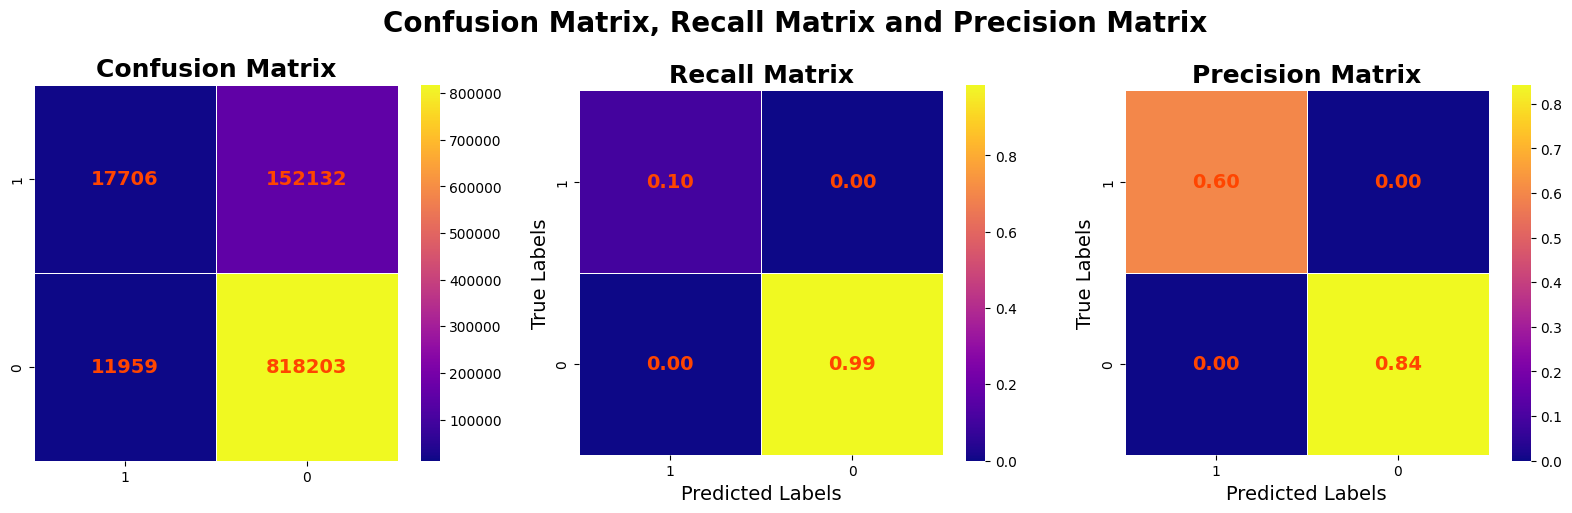

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

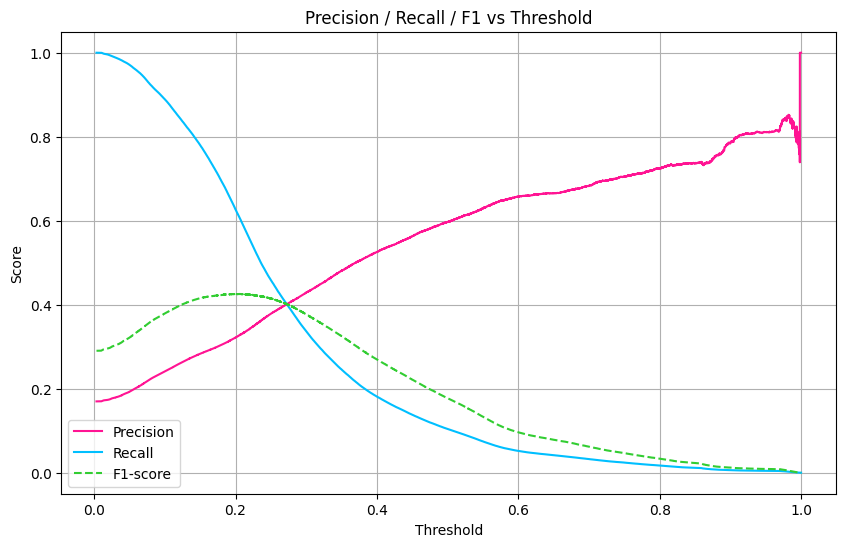

In [ ]:
three_lines_curve(y_test, y_pred_prob)

Với mức `threshold` là 0.24, thì cả 2 chỉ số đặt ở mức cân bằng và bằng nhau. Nhưng dù tăng hay giảm `threshold` thì một trong 2 chỉ số sẽ tăng lên, còn chỉ số còn lại sẽ giảm theo hướng ngược lại.

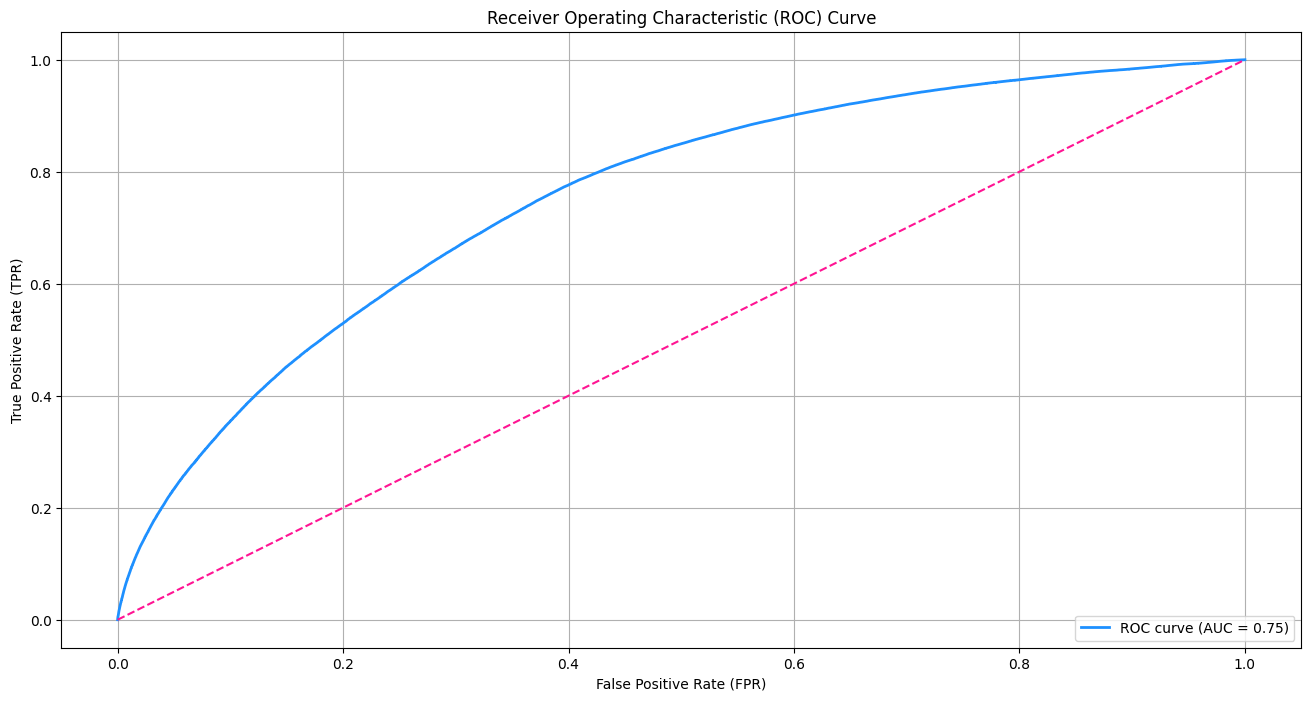

In [ ]:
roc_auc(y_test, y_pred_prob)

Mô hình phân biệt được hai lớp khá ổn (ROC AUC = 0.75), nhưng hiện tại quá bảo thủ trong việc dự đoán dương tính. Nó chọn lọc kỹ, nên precision khá cao, nhưng kết quả là recall lại cực thấp. Trong thực tế, nếu bạn đang làm bài toán như phát hiện gian lận, click ads, hay phát hiện bệnh, recall thấp là rất nguy hiểm, vì mô hình sẽ bỏ sót rất nhiều trường hợp quan trọng.

Bây giờ chúng ta sẽ thử cải tiến mô hình của chúng ta bằng cách chỉnh định tham số `class_weight = 'balanced'`, tham số này giúp điều chỉnh mô hình của chúng ta giúp mô hình học tốt hơn với tập dữ liệu mất cân bằng. 

In [ ]:
lr = LogisticRegression(solver='qn', class_weight='balanced', max_iter=5000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.6594
Recall: 0.7271282045243114
Precision: 0.2956169958108917
F1 Score(macro): 0.5895971887068385
F1 Score(weighted): 0.7013603565204463
Log loss: 0.5928112161893537


Như ta thấy được, `accuray = 0.65` cho thấy mô hình của chúng ta đã tránh được `overfitting` như mô hình tham số mặc định. `Recall = 0.72` chứng tỏ mô hình không còn bảo thủ trong việc dự đoán lớp dương nữa. Tuy nhiên tham số `precision = 0.29` lại giảm mạnh, mô hình đã tăng số lượng dự đoán lớp dương lên để tăng tham số recall khi lại gặp vấn đề khi phân biệt giữa lớp dương và lớp âm. Đây là một sự đánh đổi. Trong mô hình này `log loss` tặng mạnh.

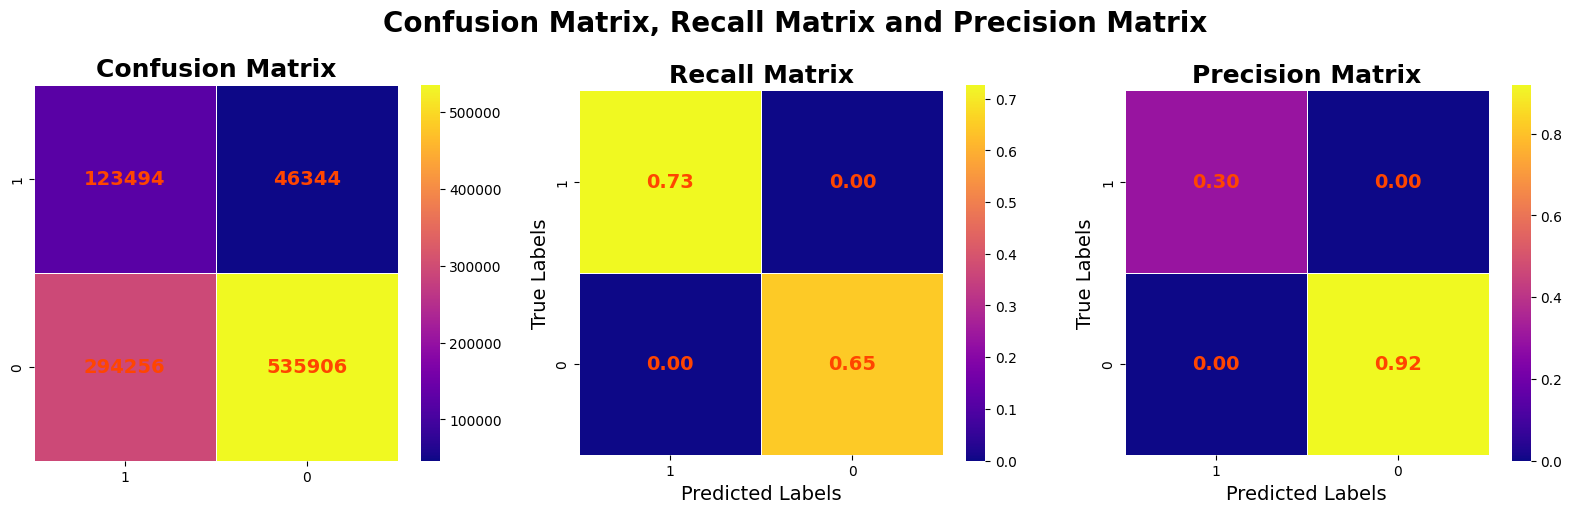

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

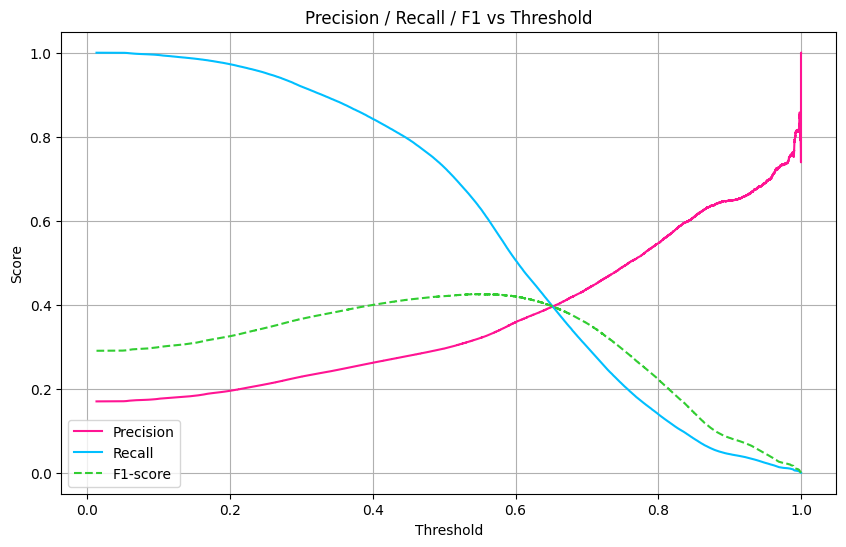

In [ ]:
three_lines_curve(y_test, y_pred_prob)

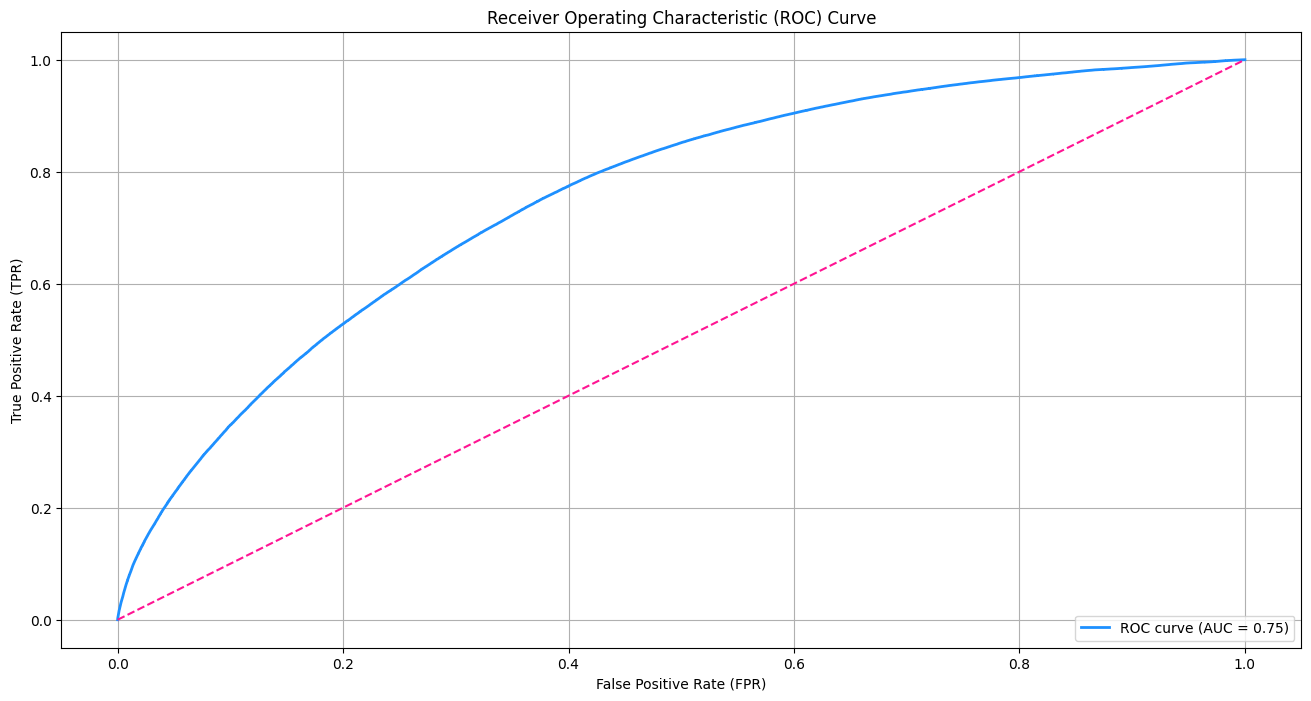

In [ ]:
roc_auc(y_test, y_pred_prob)

Đường cong ROC nhìn chung không có sự thay đổi đáng kể.

#### 2. SGDC

`CalibratedClassifierCV` trong scikit-learn dùng để **hiệu chỉnh xác suất dự đoán** của mô hình phân loại sao cho **xác suất phản ánh đúng mức độ tin cậy**.  

Một số mô hình như SVM, Random Forest thường dự đoán xác suất không chính xác. `CalibratedClassifierCV` giúp điều chỉnh lại bằng các phương pháp như **sigmoid (Platt scaling)** hoặc **isotonic regression**.  

Ứng dụng trong các bài toán cần xác suất chuẩn như **dự đoán click quảng cáo (CTR), rủi ro tài chính, y tế**, v.v.

In [ ]:
clf = SGDClassifier(loss='log_loss', class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

y_pred_prob = sig_clf.predict_proba(X_test)
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.664753
Recall: 0.71735418457589
Precision: 0.29782657054784306
F1 Score(macro): 0.5924977206176543
F1 Score(weighted): 0.7058047610082359
Log loss: 0.39747968181959
Precision: 0.29428599389430316
F1 Score(macro): 0.5882607861215075
F1 Score(weighted): 0.7001438609498795
Log loss: 0.39745387857342657


Mô hình `SGDC` với các chỉ số `accuracy, recall và precision` tương tự như mô hình hồi quy `Logistic` với paramater `class_weight = 'balanced'`. Tuy nhiên có một điểm cải thiện ở đây là `log loss` lúc này chỉ còn `0.39`, đã cải thiện đáng kể so với các mô hình trước đó.

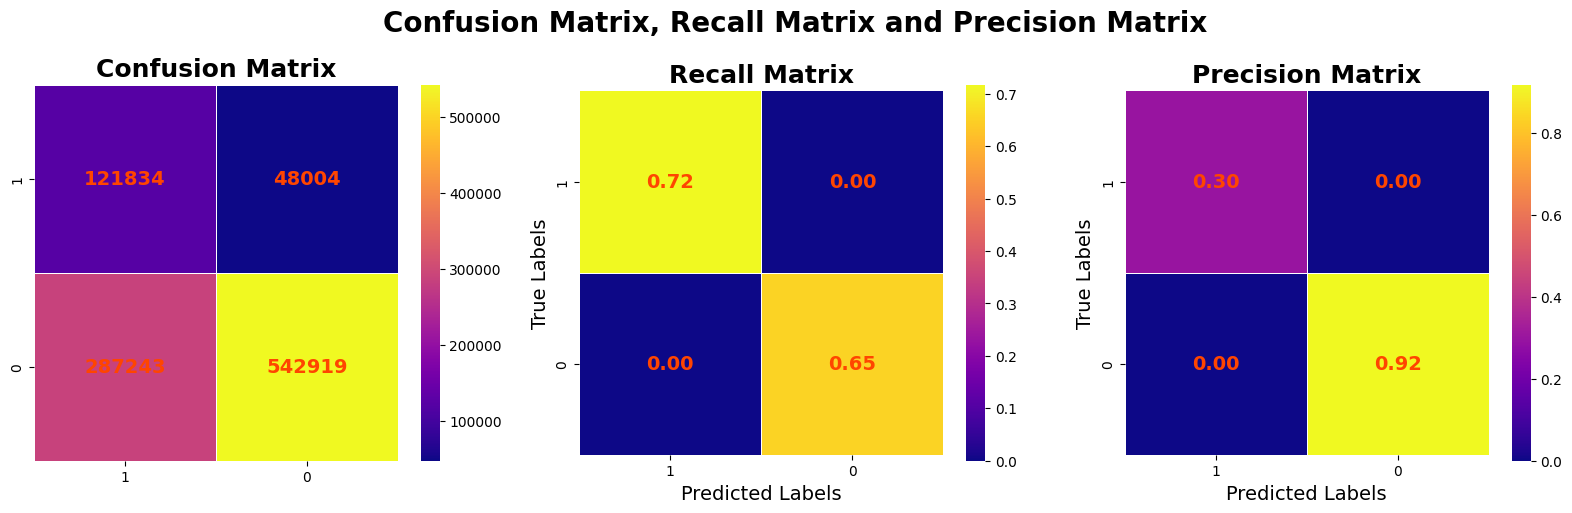

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

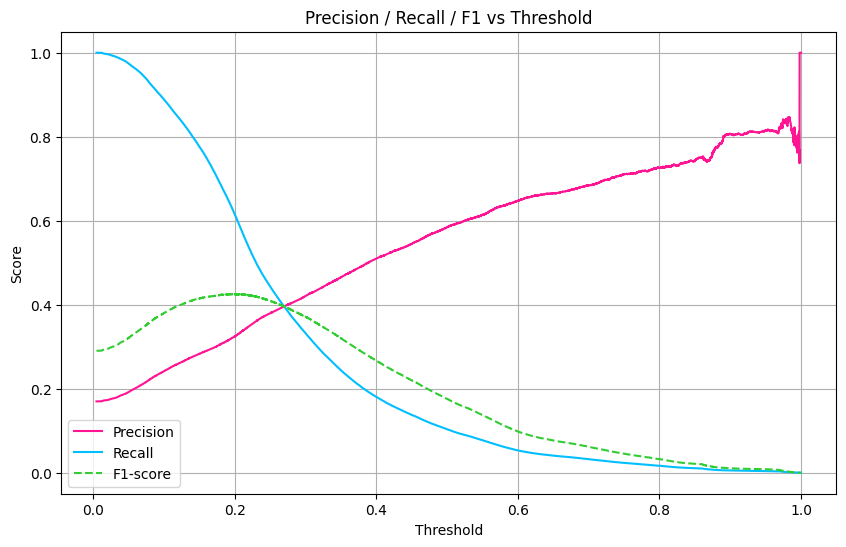

In [ ]:
three_lines_curve(y_test, y_pred_prob)

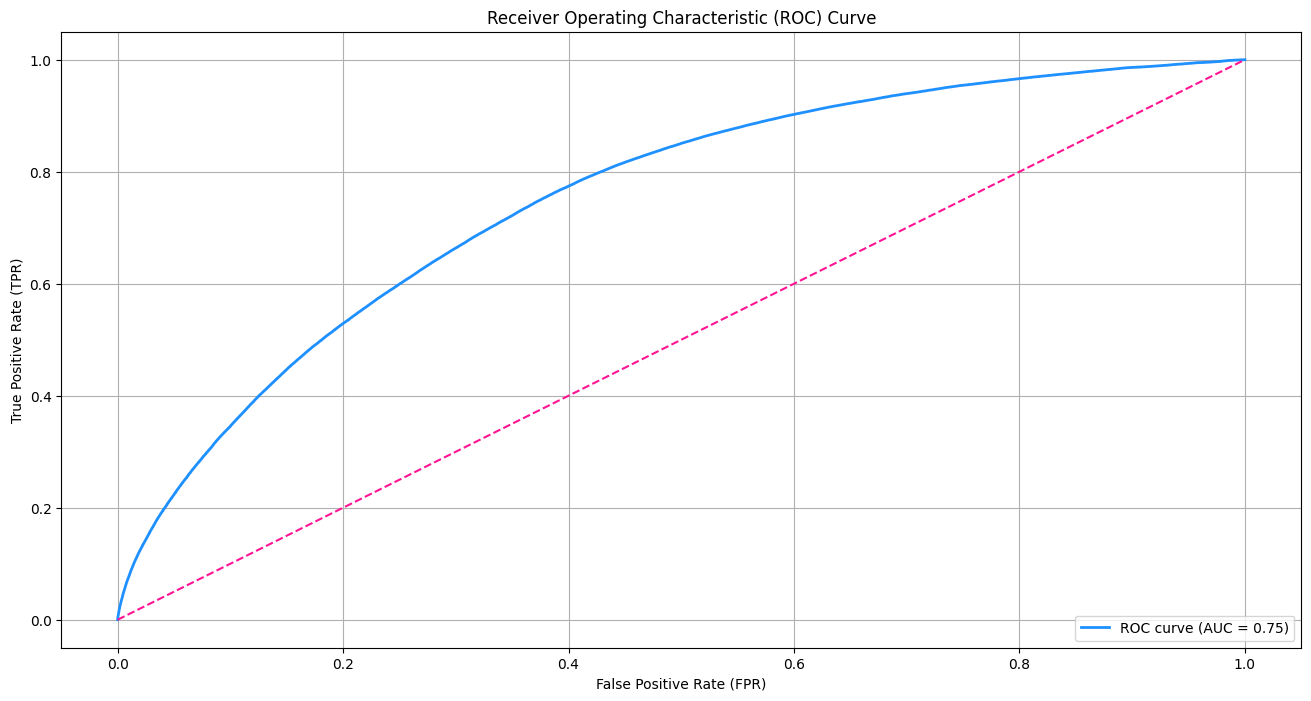

In [ ]:
roc_auc(y_test, y_pred_prob)

Đường cong `ROC` và các đường `recall, precision` nhìn chúng giống với mô hình hồi quy `Logistic` có tham số là `balanced`.

Chúng ta sẽ thử huấn luyện lại mô hình `SGDClassifier` với mức `alpha` khác nhau để xem liệu hiệu suất mô hình của chúng ta sẽ thay đổi như thế nào.

In [ ]:
alpha = [10 ** x for x in range(-5, 2)]

log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42, class_weight={0: 1, 1: 1.75})
    clf.fit(X_train, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    y_pred_prob = sig_clf.predict_proba(X_test)

    log_error_array.append(metrics.log_loss(y_test, y_pred_prob, labels=sig_clf.classes_))

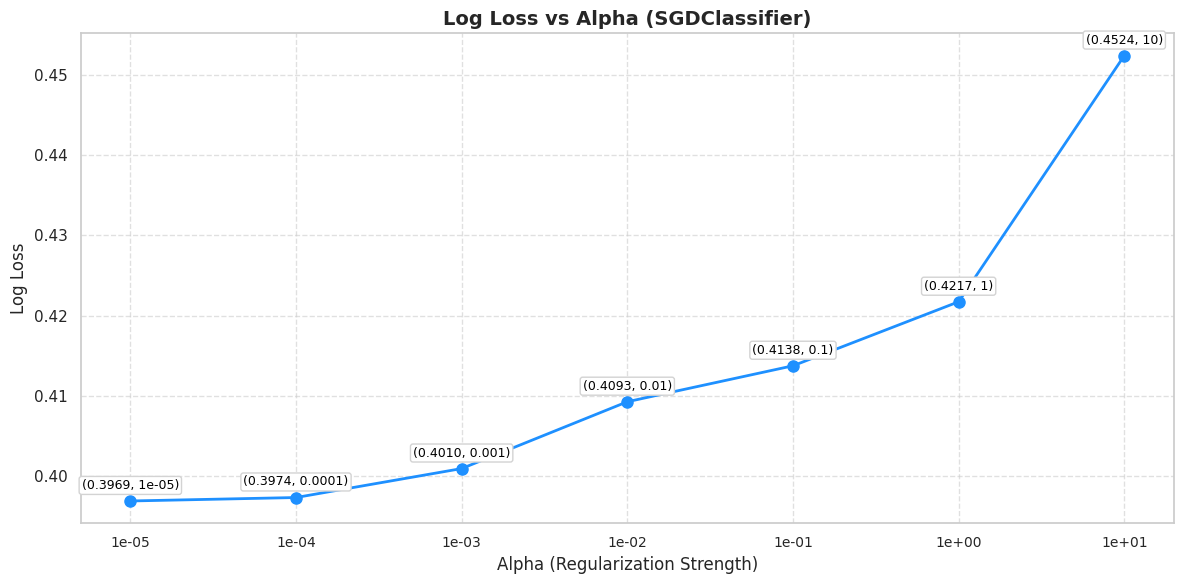

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(range(len(alpha)), log_error_array, marker='o', color='dodgerblue', linewidth=2, markersize=8)

plt.xticks(range(len(alpha)), [f"{a:.0e}" for a in alpha], fontsize=10)
plt.xlabel("Alpha (Regularization Strength)", fontsize=12)
plt.ylabel("Log Loss", fontsize=12)
plt.title("Log Loss vs Alpha (SGDClassifier)", fontsize=14, weight='bold')

for i, loss in enumerate(log_error_array):
    plt.text(i, loss + 0.0015, f"({loss:.4f}, {alpha[i]})",
             ha='center', fontsize=9, color='black',
             bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.2'))

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Dựa vào biểu đồ bên trên, ta thấy mô hình hoạt động tốt nhất với mức alpha `1e-05` với `log loss` là `0.3969`. Khi `alpha` tăng lên, `log loss` cũng tăng lên.

In [ ]:
best_alpha = alpha[np.argmin(log_error_array)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42, class_weight={0: 1, 1: 1.75})
clf.fit(X_train, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
y_pred_prob = sig_clf.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.664753
Recall: 0.71735418457589
Precision: 0.29782657054784306
F1 Score(macro): 0.5924977206176543
F1 Score(weighted): 0.7058047610082359
Log loss: 0.3969324113038455
Precision: 0.29428599389430316
F1 Score(macro): 0.5882607861215075
F1 Score(weighted): 0.7001438609498795
Log loss: 0.39689324238961093


Với `alpha = 1e-05`, mô hình của chúng ta có cải thiện đôi chút nhưng không đáng kể.

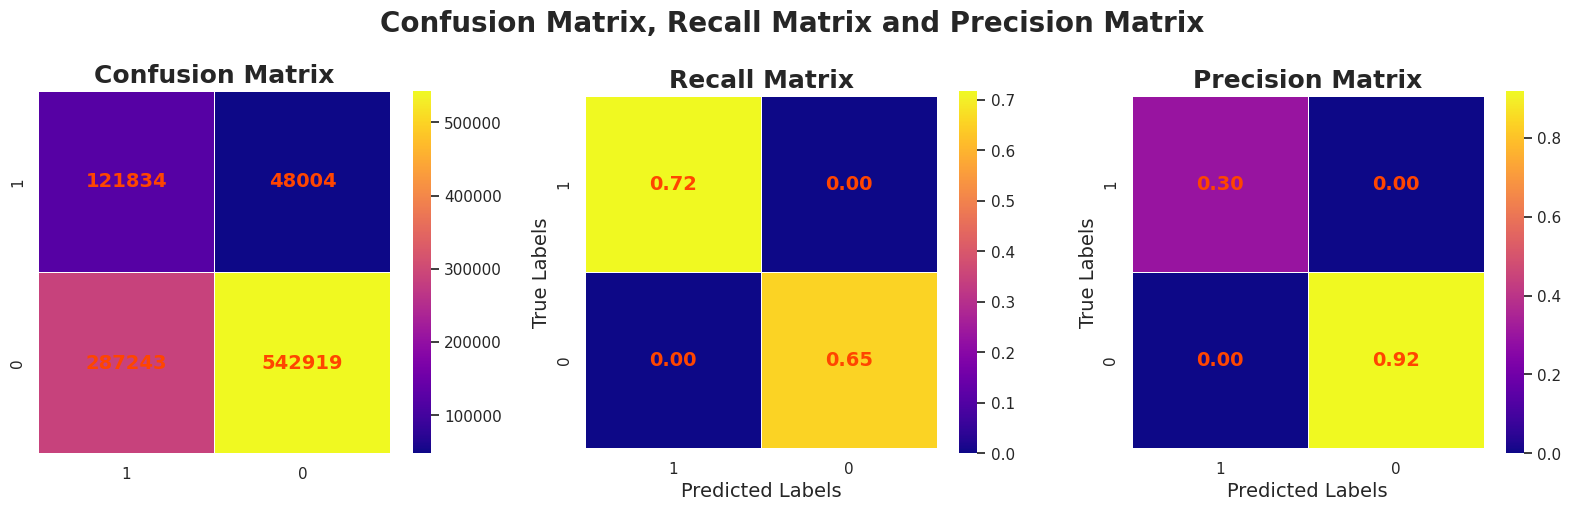

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

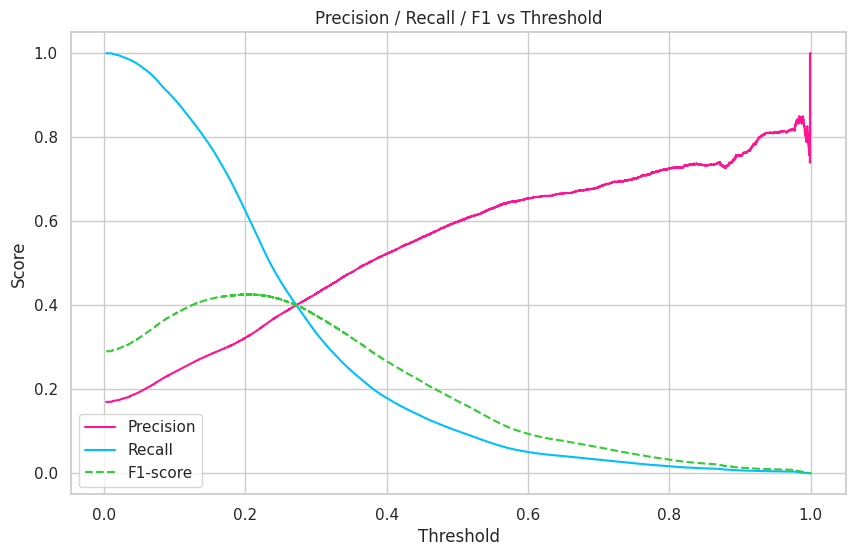

In [ ]:
three_lines_curve(y_test, y_pred_prob)

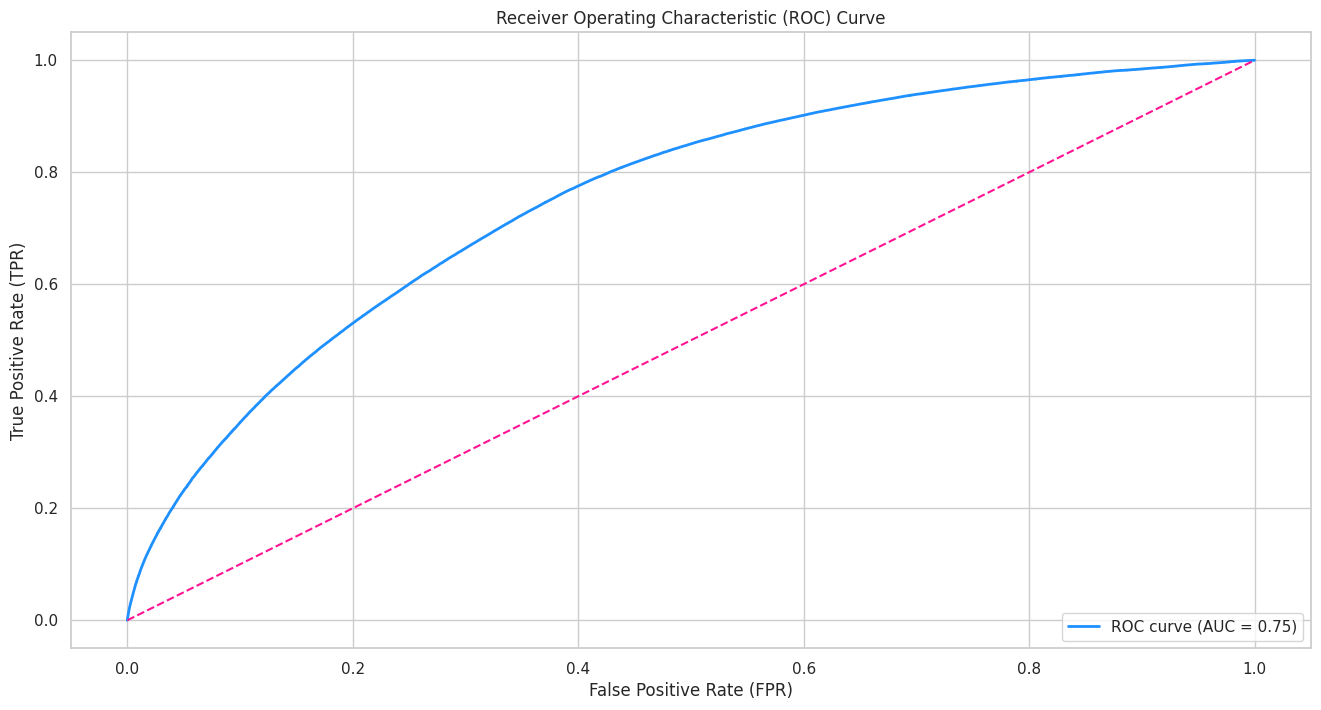

In [ ]:
roc_auc(y_test, y_pred_prob)

Các chỉ số khác cũng không có sự thay đổi.

#### 3. Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

sig_clf = CalibratedClassifierCV(dtc, method='sigmoid')
sig_clf.fit(X_train, y_train)
y_pred_prob = sig_clf.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.869589
Recall: 0.606307186848644
Precision: 0.6183844680250539
F1 Score(macro): 0.7669486851186644
F1 Score(weighted): 0.8690759847937944
Log loss: 0.302827915100212
F1 Score(weighted): 0.7874033871063869
Log loss: 0.41445806313921557


Với `Decision Tree`, chúng ta đã cải thiện được các chỉ số như `accuracy = 0.86, recall = 0.6 và precision = 0.61`. Nhưng so với các mô hình trước đó, `log loss` đã tăng lên một chút với lỗi là `0.41`, tuy nhiên sự tăng lên này lại không đáng kể. Qua đó cho thấy, mô hình `Decision Tree` của chúng ta hoạt động tốt và có tiềm năng để `deloy`.

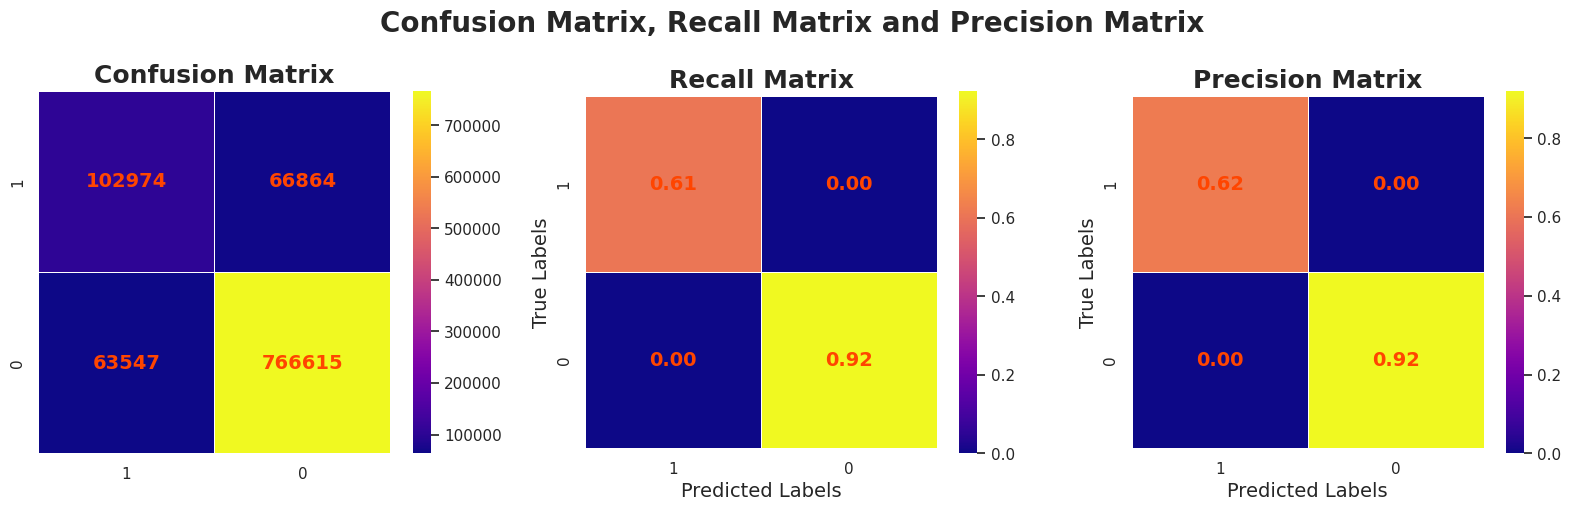

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

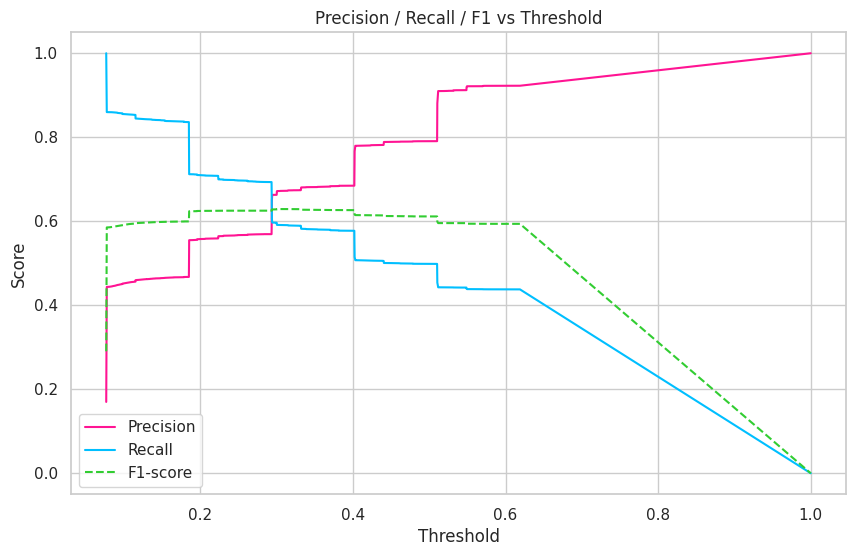

In [ ]:
three_lines_curve(y_test, y_pred_prob)

Các đường `recall` và `precision` của mô hình `Decision Tree` đã cải thiện đáng kể.

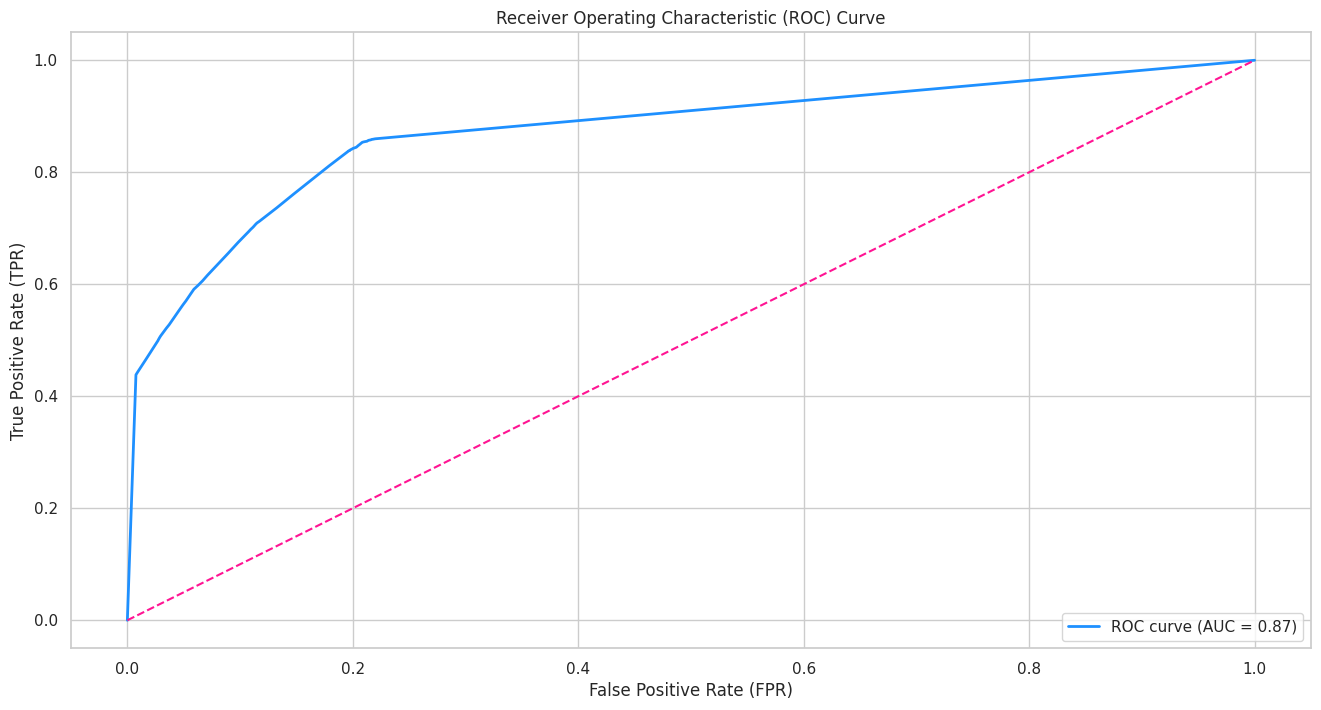

In [ ]:
roc_auc(y_test, y_pred_prob)

Ngoài ra, đường cong `ROC` cũng khá cao với `AUC = 0.87`.

#### 4. Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

sig_clf = CalibratedClassifierCV(rfc, method='sigmoid')
sig_clf.fit(X_train, y_train)
y_pred_prob = sig_clf.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.90646
Recall: 0.5404267596179889
Precision: 0.8556286822283541
F1 Score(macro): 0.8040760098543434
F1 Score(weighted): 0.8975986839941719
Log loss: 0.2246462119437478


Với mô hình `Random Forest`, cho thấy mô hình đã tăng số lượng dự đoán lớp dương lên để tăng `Precision`, tuy nhiên điều này lại làm giảm `Recall`. Với `log loss`, ta thấy một sự cải thiện khá đáng kể khi `log loss` bây giờ chỉ còn là `0.22`. Ngoài ra `accuracy` cũng khá ấn tượng với `0.9`. Đây là một mô hình tốt.

Chúng ta sẽ quan sát các đường `recall, precision` và `ROC` xem liệu mô hình này hoạt động như thế nào.

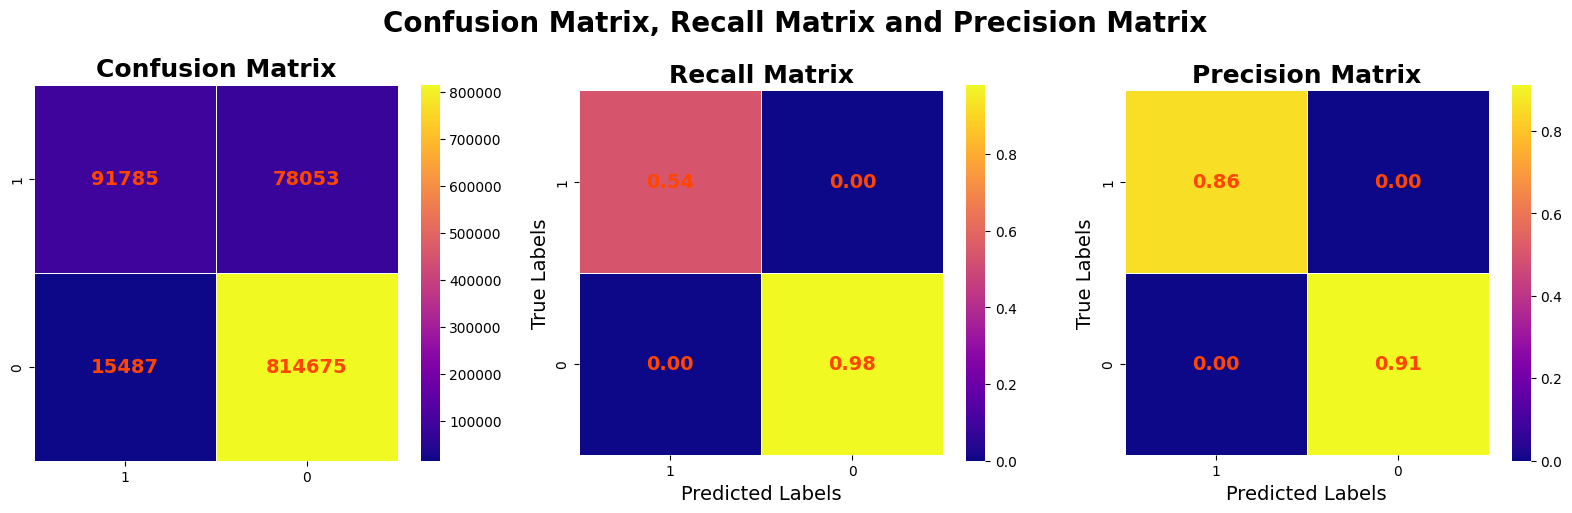

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

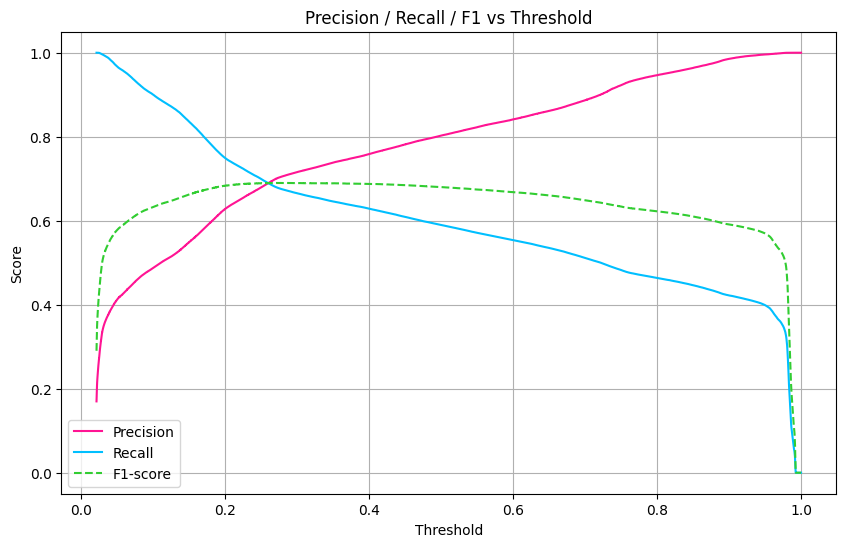

In [ ]:
three_lines_curve(y_test, y_pred_prob)

Với các đường `recall` và `precision`, giao điểm của chúng ở mức khá cao, đâu đó là `0.7`, điều mà các mô hình trước đó không làm được.

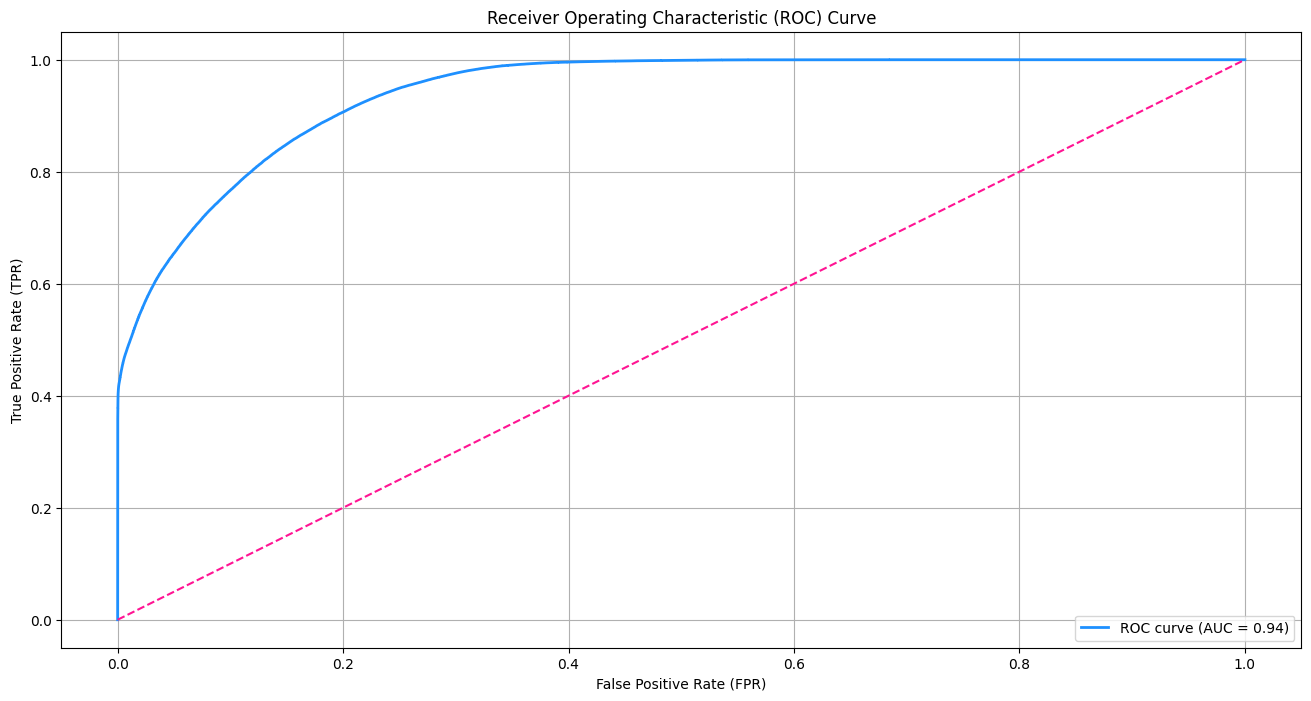

In [ ]:
roc_auc(y_test, y_pred_prob)

Đường cong `roc` cho chúng ta một giá trị khá ấn tượng, là `0.94`. Điều này chứng minh mô hình chúng ta phân biệt khá tốt giữa lớp âm và lớp dương.

### Balanced Ramdom Forest

In [ ]:
# Apply RandomUnderSampler (CPU-based)
# rus = RandomUnderSampler(random_state=42)
# X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

In [4]:
# # Train cuML RandomForestClassifier
# rfc = RandomForestClassifier()
# rfc.fit(X_train_res, y_train_res)

# sig_clf = CalibratedClassifierCV(rfc, method='sigmoid')
# sig_clf.fit(X_train_res, y_train_res)
# y_pred_prob = sig_clf.predict_proba(X_test)

# print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
# print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
# print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
# print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
# print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
# print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

In [5]:
# plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

In [6]:
# three_lines_curve(y_test, y_pred_prob)

In [7]:
# roc_auc(y_test, y_pred_prob)

#### 5. XGBoost Classifier

**XGBoost Classifier** là một thuật toán học máy mạnh mẽ dựa trên phương pháp **gradient boosting**, được thiết kế tối ưu về hiệu năng và tốc độ. Tên đầy đủ là **Extreme Gradient Boosting**.

### Đặc điểm nổi bật:
- **Hiệu suất cao**: Tối ưu hóa tính toán, hỗ trợ song song hóa và GPU.
- **Chống overfitting tốt**: Nhờ các kỹ thuật regularization (L1, L2).
- **Làm việc tốt với dữ liệu mất cân bằng** và dữ liệu có nhiều đặc trưng.
- **Tùy biến linh hoạt**: Hỗ trợ nhiều hàm mất mát và tham số.

### Ứng dụng:
- Phân loại nhị phân và đa lớp (ví dụ: chẩn đoán bệnh, phân loại khách hàng, phát hiện gian lận).
- Đạt nhiều thành tích cao trong các cuộc thi Kaggle.

Trước tiên, chúng ta cần chỉ định một số tham số cho mô hình `XGBoost`.

In [ ]:
params = {
    'tree_method': 'hist',          # GPU-accelerated histogram method
    'device': 'cuda',               # Use GPU
    'n_estimators': 100,            # Number of trees
    'max_depth': 6,                 # Max tree depth
    'learning_rate': 0.1,           # Learning rate
    'objective': 'binary:logistic', # Binary classification
    'eval_metric': 'logloss'        # Evaluation metric
}

xgbc = XGBClassifier(**params)
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)

sig_clf = CalibratedClassifierCV(xgbc, method='sigmoid')
sig_clf.fit(X_train, y_train)
y_pred_prob = sig_clf.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.906966
Recall: 0.5465208021761915
Precision: 0.8528428093645485
F1 Score(macro): 0.8060534253340164
F1 Score(weighted): 0.8984318990806177
Log loss: 0.22219045187527164


So với mô hình `Random Forest`, thì `XGB` cho chúng ta một kết quả tương tự.

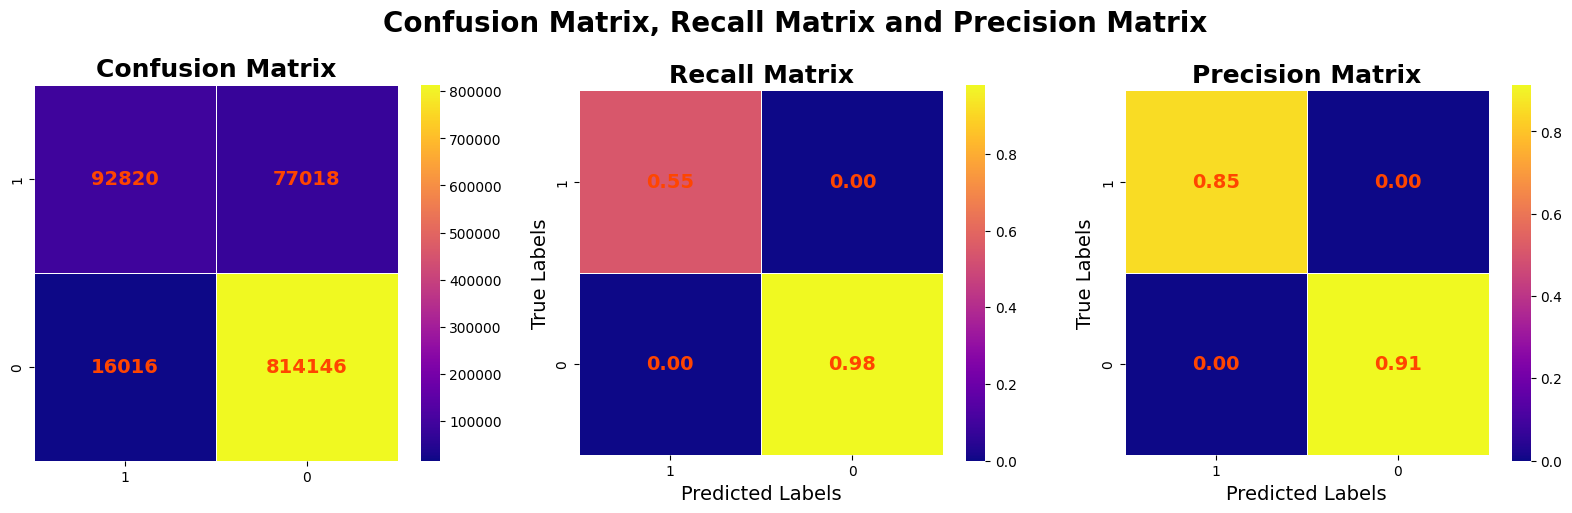

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

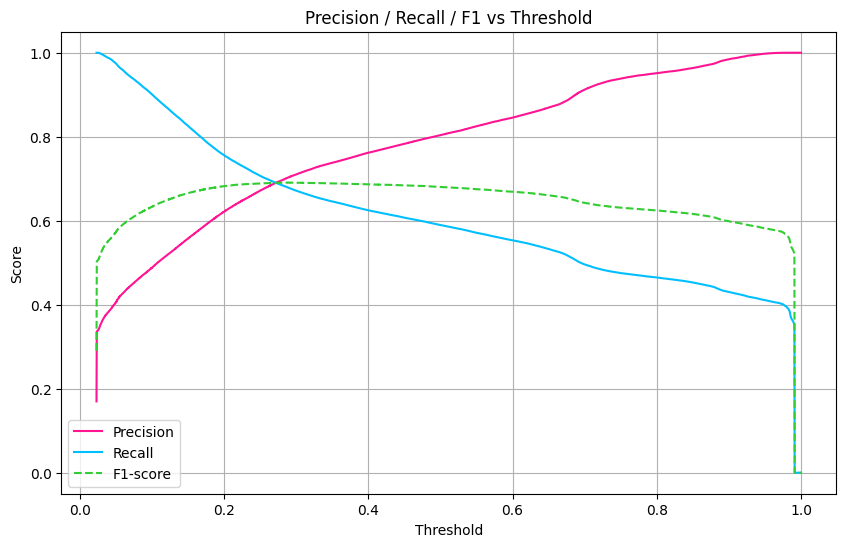

In [ ]:
three_lines_curve(y_test, y_pred_prob)

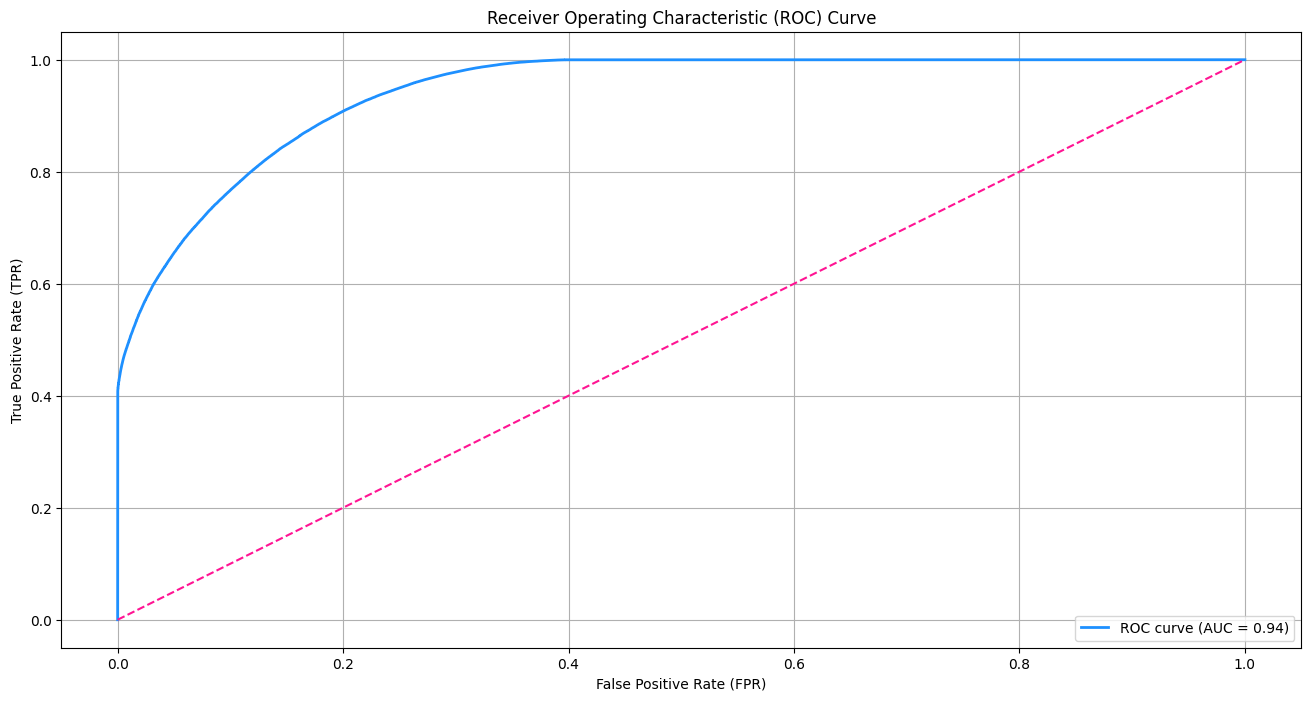

In [ ]:
roc_auc(y_test, y_pred_prob)

Đường cong `roc` cũng giống hệt như `Random Forest Classifier`.

#### 6. Catboost Classfier

**CatBoost Classifier** là một thuật toán học máy thuộc họ **gradient boosting**, được phát triển bởi **Yandex**. Nó nổi bật với khả năng xử lý **dữ liệu phân loại (categorical)** hiệu quả mà **không cần phải mã hóa (one-hot hay label encoding)** như các thuật toán khác.

##### Đặc điểm nổi bật:
- **Xử lý trực tiếp dữ liệu phân loại**.
- **Giảm overfitting** tốt nhờ thuật toán boosting có cải tiến.
- **Hiệu suất cao**, dễ sử dụng, ít cần tinh chỉnh.
- **Tích hợp sẵn nhiều tính năng như hỗ trợ GPU, early stopping, cross-validation**.

##### Ứng dụng:
- Phân loại dữ liệu trong các bài toán như: chấm điểm tín dụng, phân tích khách hàng, dự đoán hành vi người dùng, v.v.

In [ ]:
# Initialize CatBoost with GPU
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    task_type='GPU',         # Enable GPU
    devices='0',             # Use first GPU
    random_seed=42,
    verbose=50
)

# Train
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.4493703	test: 0.4492409	best: 0.4492409 (0)	total: 69.3ms	remaining: 34.6s
50:	learn: 0.2040789	test: 0.2038480	best: 0.2038480 (50)	total: 2.56s	remaining: 22.5s
100:	learn: 0.2020552	test: 0.2018942	best: 0.2018942 (100)	total: 5.12s	remaining: 20.2s
150:	learn: 0.2012928	test: 0.2012130	best: 0.2012130 (150)	total: 7.62s	remaining: 17.6s
200:	learn: 0.2006786	test: 0.2006708	best: 0.2006708 (200)	total: 10.1s	remaining: 15.1s
250:	learn: 0.2003191	test: 0.2003762	best: 0.2003762 (250)	total: 12.7s	remaining: 12.6s
300:	learn: 0.2000344	test: 0.2001558	best: 0.2001558 (300)	total: 15.2s	remaining: 10.1s
350:	learn: 0.1998022	test: 0.1999945	best: 0.1999945 (350)	total: 17.7s	remaining: 7.53s
400:	learn: 0.1996158	test: 0.1998737	best: 0.1998737 (400)	total: 20.3s	remaining: 5.02s
450:	learn: 0.1993968	test: 0.1997207	best: 0.1997207 (450)	total: 22.8s	remaining: 2.48s
499:	learn: 0.1992798	test: 0.1996667	best: 0.1996667 (499)	total: 25.3s	remaining: 0us
bestTest = 0.1996

In [ ]:
y_pred = model.predict(X_test)
sig_clf = CalibratedClassifierCV(model, method='sigmoid')
sig_clf.fit(X_train, y_train)

y_pred = sig_clf.predict(X_test)
y_pred_prob = sig_clf.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

0:	learn: 0.4500327	total: 57.2ms	remaining: 28.6s
50:	learn: 0.2040053	total: 2.11s	remaining: 18.6s
100:	learn: 0.2024046	total: 4.16s	remaining: 16.4s
150:	learn: 0.2013385	total: 6.22s	remaining: 14.4s
200:	learn: 0.2009046	total: 8.25s	remaining: 12.3s
250:	learn: 0.2005348	total: 10.3s	remaining: 10.3s
300:	learn: 0.2002698	total: 12.4s	remaining: 8.22s
350:	learn: 0.1999575	total: 14.5s	remaining: 6.16s
400:	learn: 0.1997752	total: 16.6s	remaining: 4.1s
450:	learn: 0.1996109	total: 18.7s	remaining: 2.03s
499:	learn: 0.1993764	total: 20.7s	remaining: 0us
0:	learn: 0.4500847	total: 58.8ms	remaining: 29.4s
50:	learn: 0.2040635	total: 2.16s	remaining: 19s
100:	learn: 0.2022730	total: 4.22s	remaining: 16.7s
150:	learn: 0.2014234	total: 6.24s	remaining: 14.4s
200:	learn: 0.2007960	total: 8.29s	remaining: 12.3s
250:	learn: 0.2004366	total: 10.3s	remaining: 10.2s
300:	learn: 0.2001935	total: 12.4s	remaining: 8.18s
350:	learn: 0.2000004	total: 14.4s	remaining: 6.1s
400:	learn: 0.1997845	

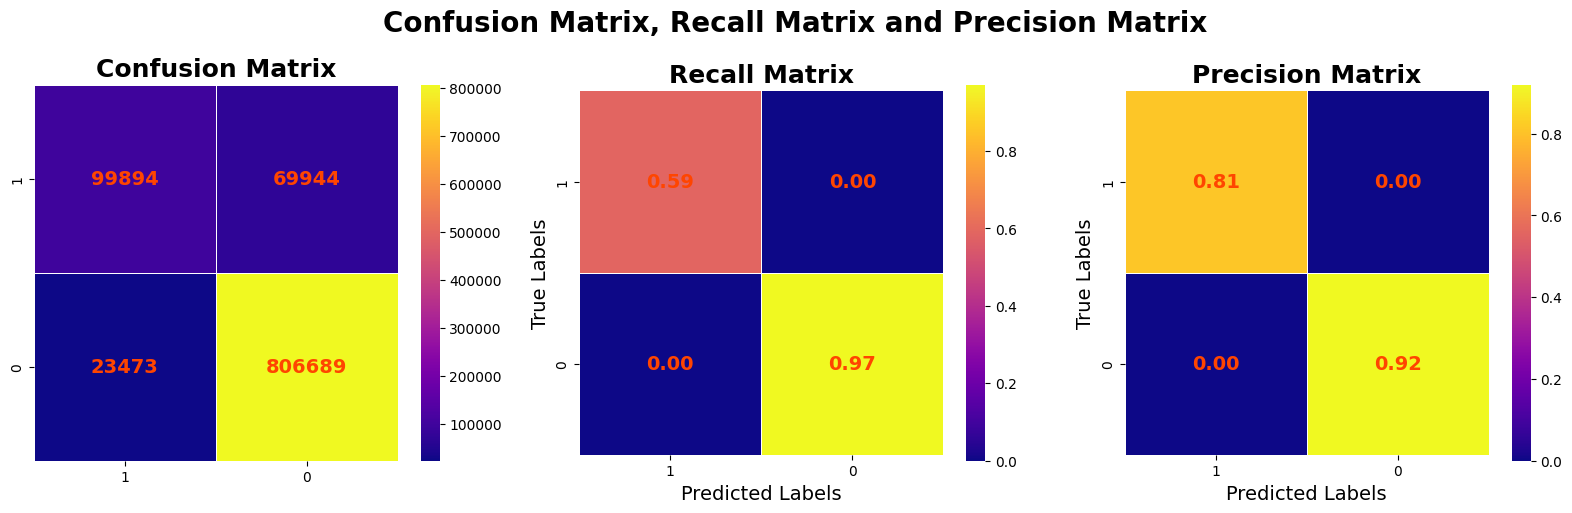

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

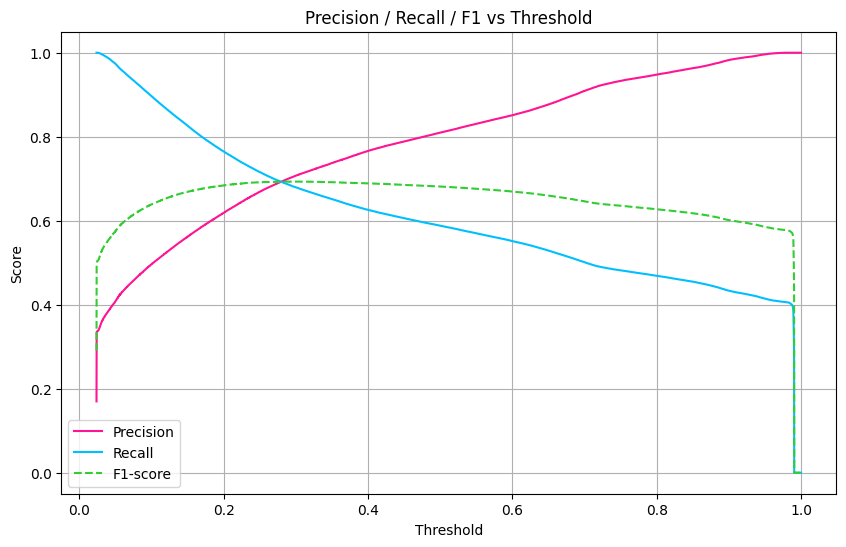

In [ ]:
three_lines_curve(y_test, y_pred_prob)

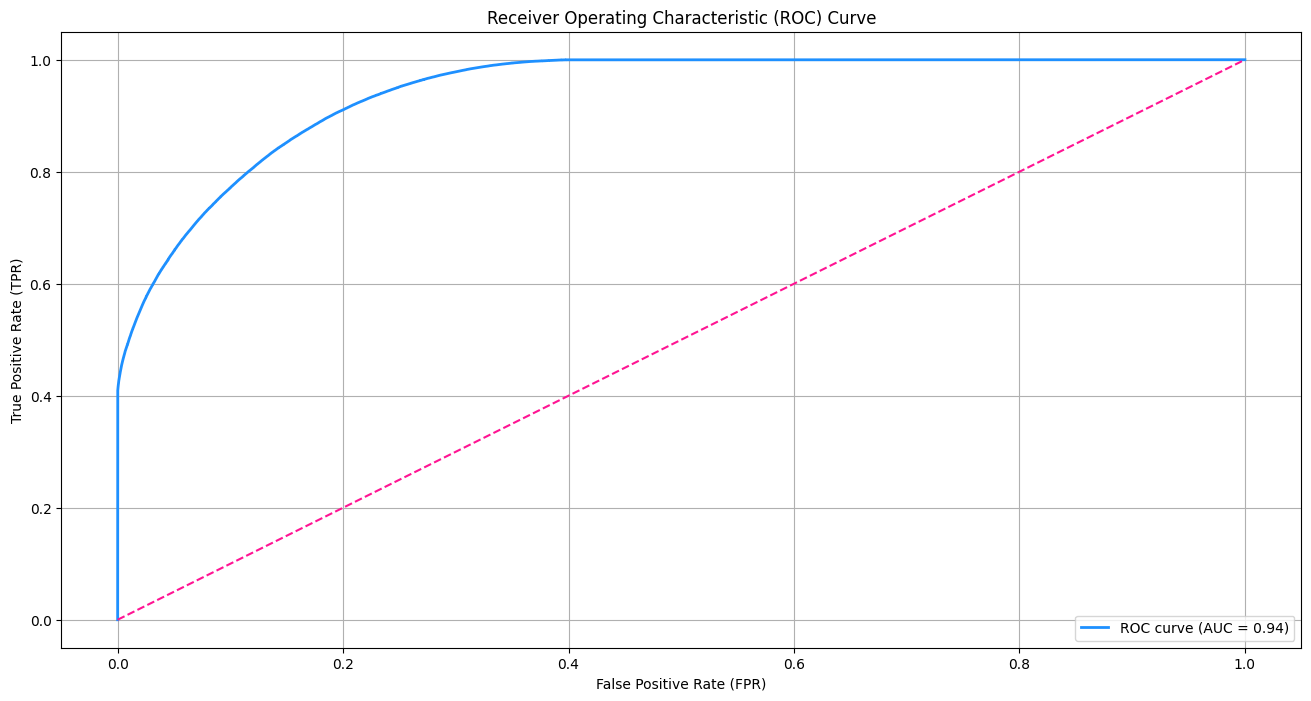

In [ ]:
roc_auc(y_test, y_pred_prob)

`Catboost Classfier` cho kết quả tương tự như `Random Forest` và `XGBoost`.

### Modeling with Hyperparamater Tuning

Chúng ta sẽ tiến hành điều chỉnh tham số của các mô hình máy học (Hyperparamater Tuning).

Vì chúng ta sử dụng thư viện `cuml`, một thư viện cung cấp các mô hình máy học tương tự như `sklearn` nhưng khác ở chỗ chúng được huấn luyện trên `GPU`, giúp tăng tốc thời gian huấn luyện lên rất nhiều lần, nên việc kết hợp với thư viện `GridSearch` hay `RandomizedSearch` trong thư viện `sklearn` sẽ gây ra lỗi, chúng ta sẽ phải viết code search bằng tay.

#### 1. Logistic Regression

In [ ]:
param_grid = {
    'C': np.linspace(0.01, 3, 10),
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced', {0: 1, 1: 5.25}],
    'fit_intercept': [True, False]
}

param_list = list(product(
    param_grid['C'],
    param_grid['penalty'],
    param_grid['class_weight'],
    param_grid['fit_intercept']
))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for C, penalty, class_weight, fit_intercept in param_list:
    log_losses = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        if penalty != 'l2':
            continue

        model = LogisticRegression(
            solver='qn',
            penalty=penalty,
            C=C,
            fit_intercept=fit_intercept,
            max_iter=5000
        )

        model.fit(X_tr, y_tr)
        y_proba = model.predict_proba(X_val)[:, 1]
        loss = metrics.log_loss(y_val, y_proba)
        log_losses.append(loss)

    if log_losses:
        avg_loss = np.mean(log_losses)
        results.append(((C, penalty, class_weight, fit_intercept), avg_loss))

[2025-04-08 06:32:12.362] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-04-08 06:32:30.585] [CUML] [warning] L-BFGS line search failed (code 3); stopping at the last valid step
[2025-04-08 06:32:40.576] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-04-08 06:32:46.974] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-04-08 06:34:01.141] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-04-08 06:34:08.397] [CUML] [warning] L-BFGS line search failed (code 3); stopping at the last valid step
[2025-04-08 06:34:25.070] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[2025-04-08 06:34:31.708] [CUML] [warning] L-BFGS line search failed (code 3); stopping at the last valid step
[2025-04-08 06:34:35.467] [CUML] [warning]

In [ ]:
min_index = min(enumerate(results), key=lambda x: x[1][1])[0]
results[min_index]

((3.0, 'l2', 'balanced', True), 0.39716592193669803)

Sau khi kết thúc công việc tìm kiếm, chúng ta nhận được các tham số cho kết quả tốt nhất.

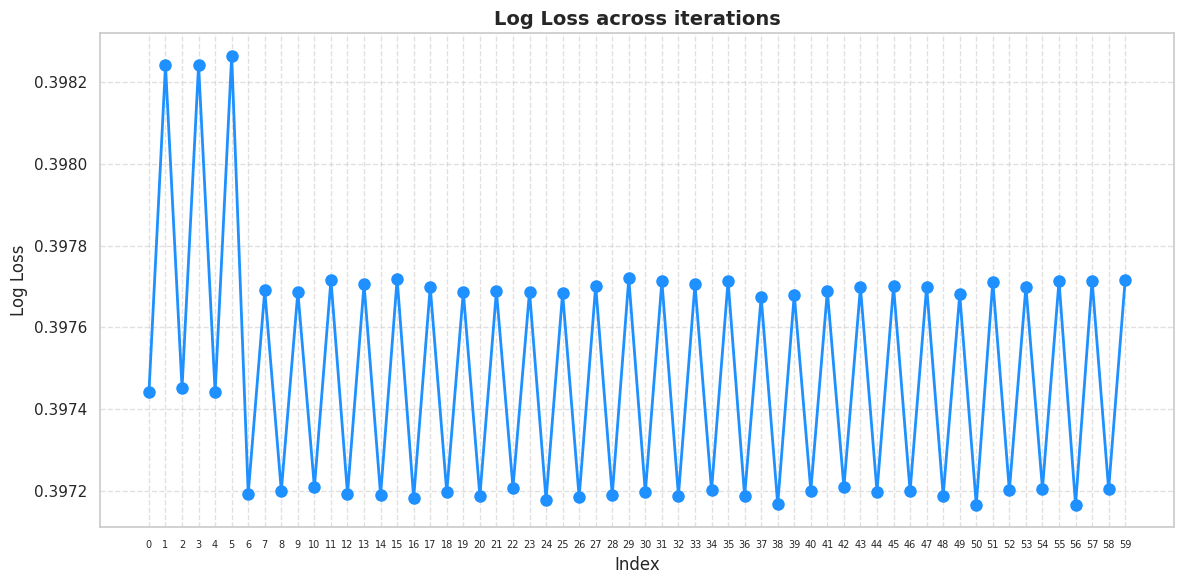

In [ ]:
log_loss_err = [x[1] for x in results]
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(range(len(log_loss_err)), log_loss_err, marker='o',
         color='dodgerblue', linewidth=2, markersize=8)

plt.xticks(range(len(log_loss_err)), [str(i) for i in range(len(log_loss_err))], fontsize=7)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Log Loss", fontsize=12)
plt.title("Log Loss across iterations", fontsize=14, weight='bold')

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
model = LogisticRaegression(
            solver='qn',
            penalty='l2',
            C=3.0,
            fit_intercept=True,
            max_iter=5000
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.835906
Recall: 0.10316301416644096
Precision: 0.5980271690900403
F1 Score(macro): 0.5424252976494042
F1 Score(weighted): 0.7844043993432682
Log loss: 0.3968182561428588


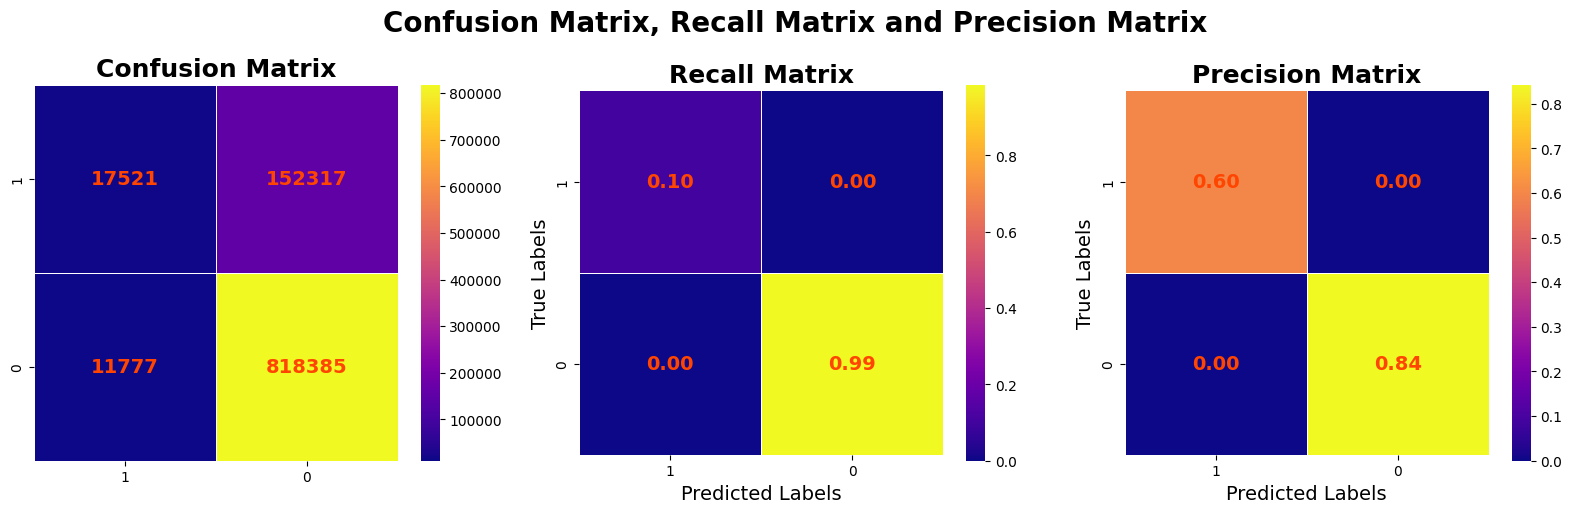

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

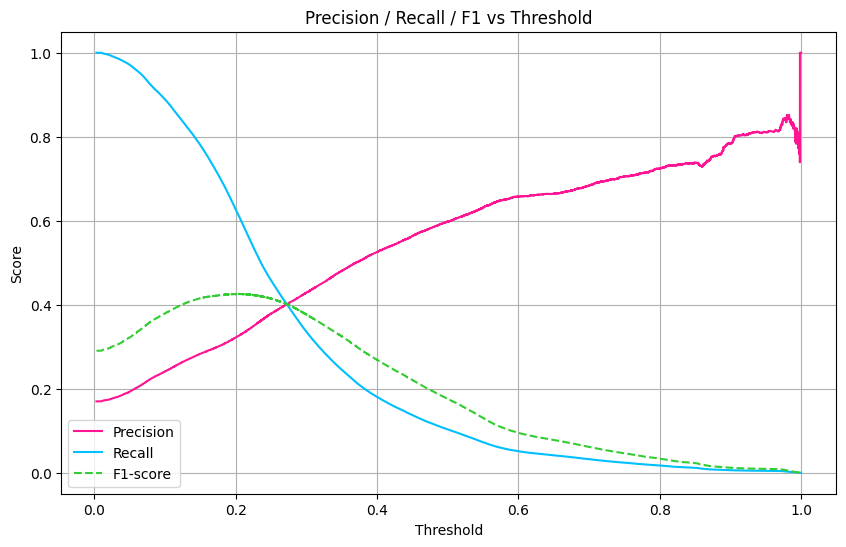

In [ ]:
three_lines_curve(y_test, y_pred_prob)

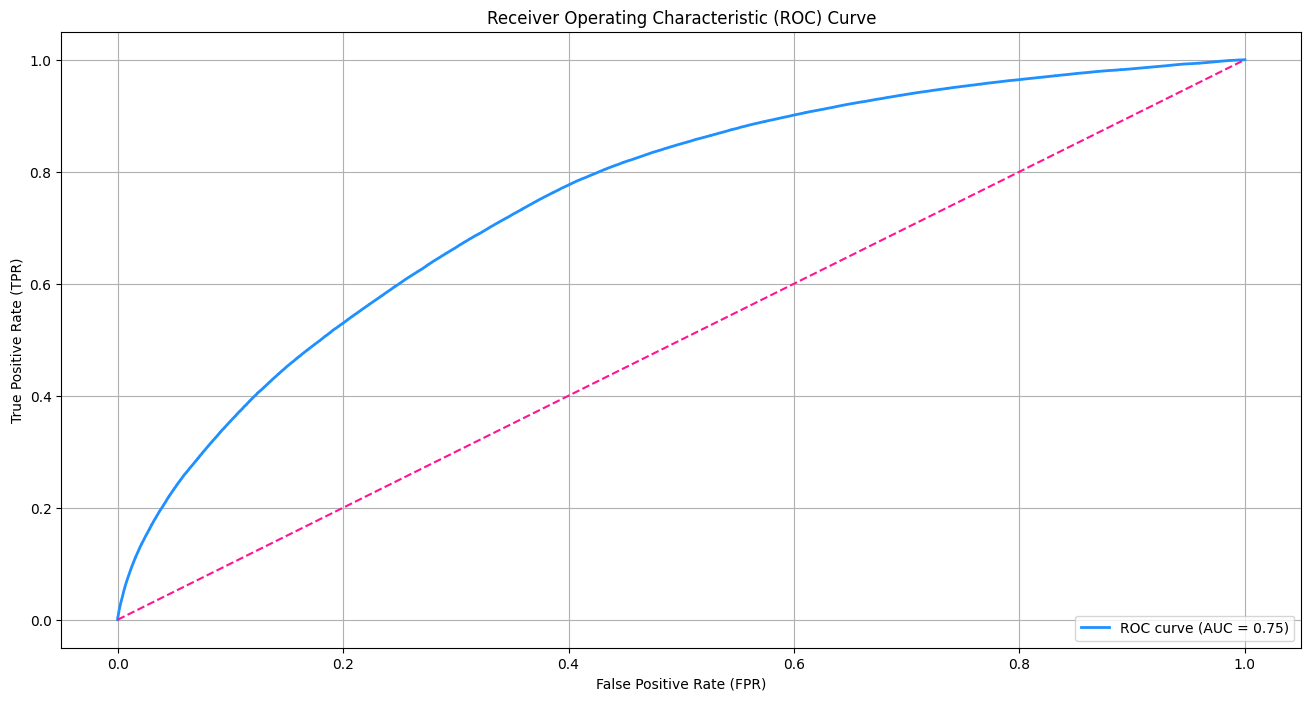

In [ ]:
roc_auc(y_test, y_pred_prob)

#### 2. Random Forest Classfier

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'split_criterion': [0, 1],
    'bootstrap': [True, False],
    'max_depth': [16, 18, 20],
    'max_features': ['sqrt', 'log2']
}

param_list = list(product(
    param_grid['n_estimators'],
    param_grid['split_criterion'],
    param_grid['bootstrap'],
    param_grid['max_depth'],
    param_grid['max_features']
))

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = []

for n_estimators, split_criterion, bootstrap, max_depth, max_features in tqdm(param_list):
    log_losses = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            split_criterion=split_criterion,
            bootstrap=bootstrap,
            max_depth=max_depth,
            max_features=max_features
        )

        model.fit(X_tr, y_tr)

        y_proba = model.predict_proba(X_val)[:, 1]
        loss = metrics.log_loss(y_val, y_proba)
        log_losses.append(loss)

    if log_losses:
        avg_loss = np.mean(log_losses)
        results.append(((n_estimators, split_criterion, bootstrap,
                         max_depth, max_features), avg_loss))

100%|██████████| 72/72 [1:54:49<00:00, 95.68s/it] 


In [ ]:
min_index = min(enumerate(results), key=lambda x: x[1][1])[0]
results[min_index]

((200, 1, False, 20, 'sqrt'), 0.20902824178646986)

In [ ]:
n_estimators, split_criterion, bootstrap, max_depth, max_features = results[min_index][0]

model = RandomForestClassifier(
            n_estimators=n_estimators,
            split_criterion=split_criterion,
            bootstrap=bootstrap,
            max_depth=max_depth,
            max_features=max_features
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

sig_clf = CalibratedClassifierCV(model, method='sigmoid')
y_pred_prob = model.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.90558
Recall: 0.5414807051425476
Precision: 0.8475163579393604
F1 Score(macro): 0.80297083377067
F1 Score(weighted): 0.8968599868267361
Log loss: 0.20843983728391338


So với mô hình `Random Forest` với tham số mặc định, thì mô hình `Random Forest` với `search` cho kết quả tốt hơn với `log loss` là `0.2`.

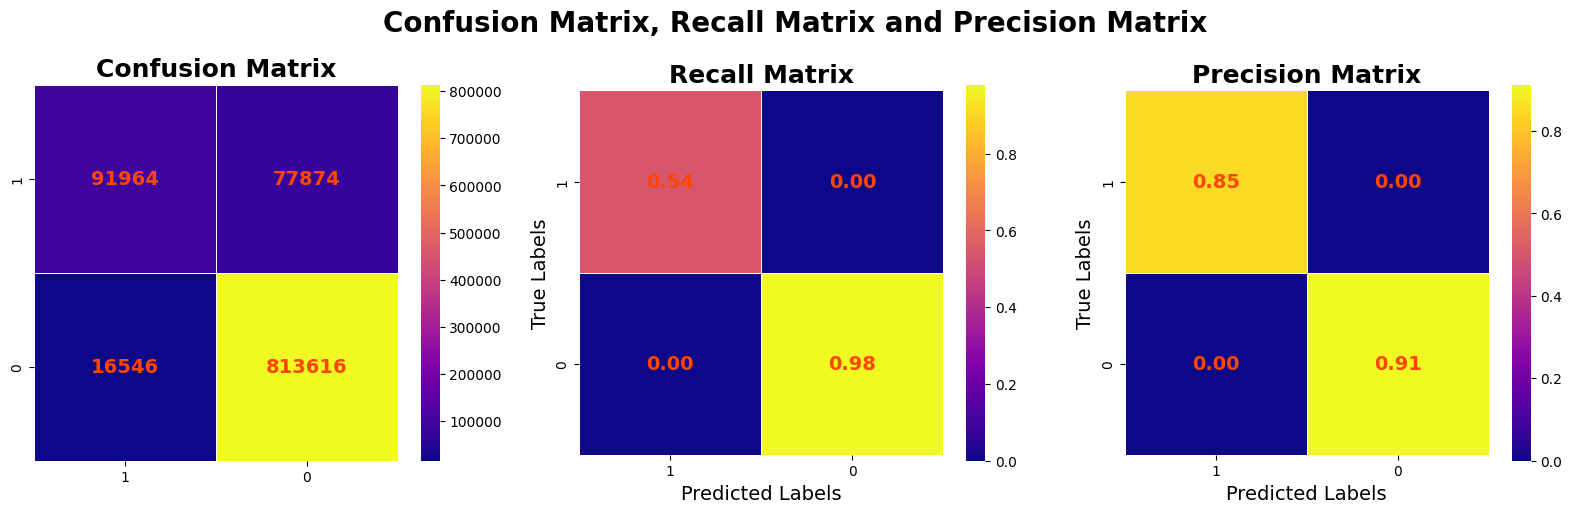

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

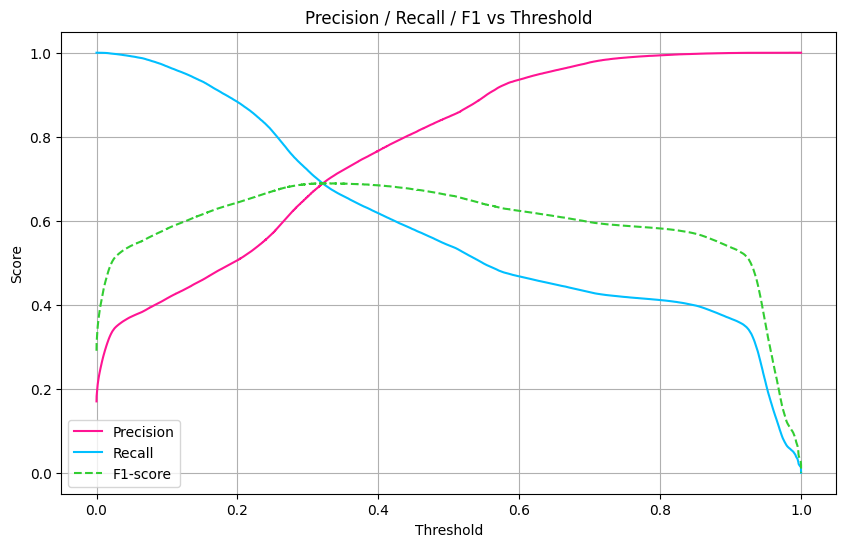

In [ ]:
three_lines_curve(y_test, y_pred_prob)

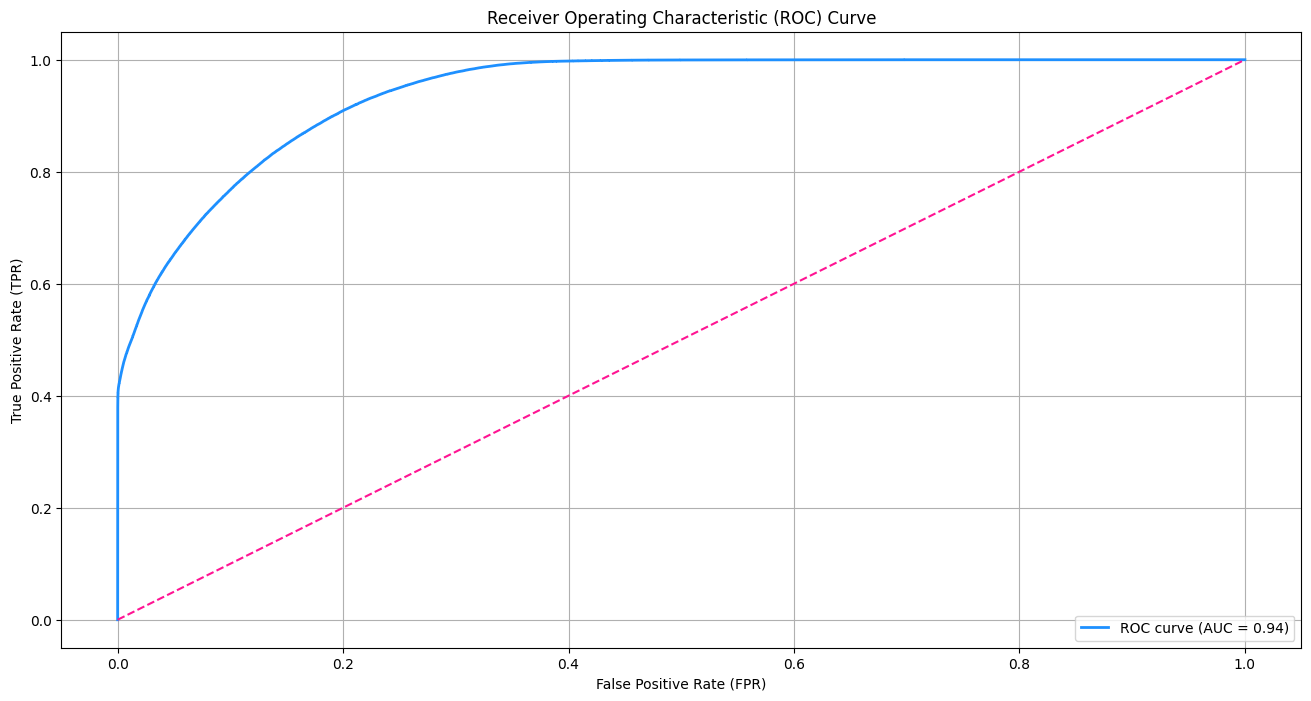

In [ ]:
roc_auc(y_test, y_pred_prob)

#### 5. XGBoost Classifier

In [ ]:
param_grid = {
    'reg_lambda': np.linspace(0.5, 5, 10),
    'reg_alpha': np.linspace(0.5, 5, 10),
    'scale_pos_weight': [1, 5.25],
    'max_depth': [3, 6, 12]
}

param_list = list(product(
    param_grid['reg_lambda'],
    param_grid['reg_alpha'],
    param_grid['scale_pos_weight'],
    param_grid['max_depth']
))

Chúng ta sẽ chuyển đổi các tập `X_train, X_test, y_train, y_test` sang `GPU` để mô hình đạt được tốc độ huấn luyện nhanh hơn và tiết kiệm bộ nhớ `RAM`.

In [ ]:
X_train_gpu = cp.asarray(X_train)
y_train_gpu = cp.asarray(y_train)
X_test_gpu = cp.asarray(X_test)
y_test_gpu = cp.asarray(y_test)

In [ ]:
results = []

for reg_lambda, reg_alpha, scale_pos_weight, max_depth in tqdm(param_list):
    params = {
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha,
        'scale_pos_weight': scale_pos_weight,
        'max_depth': max_depth,
        'tree_method': 'hist',
        'device': 'cuda',
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)
    model.fit(X_train_gpu, y_train_gpu)
    y_pred_proba = model.predict_proba(X_test_gpu)

    log_loss = metrics.log_loss(cp.asnumpy(y_test_gpu), cp.asnumpy(y_pred_proba))

    results.append(
        ((reg_lambda, reg_alpha, scale_pos_weight, max_depth), log_loss)
    )

    del model, y_pred_proba
    gc.collect()

min_index = min(enumerate(results), key=lambda x: x[1][1])[0]
results[min_index]

100%|██████████| 600/600 [1:19:34<00:00,  7.96s/it]


((3.0, 3.5, 1, 6), 0.19912662133354814)

In [ ]:
reg_lambda, reg_alpha, scale_pos_weight, max_depth = results[min_index][0]
params = {
    'reg_lambda': reg_lambda,
    'reg_alpha': reg_alpha,
    'scale_pos_weight': scale_pos_weight,
    'max_depth': max_depth,
    'tree_method': 'hist',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

model = XGBClassifier(**params)
model.fit(X_train_gpu, y_train_gpu)
y_pred = model.predict(X_test_gpu)

sig_clf = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
sig_clf.fit(X_train, y_train)
y_pred_prob = sig_clf.predict_proba(X_test)

y_pred_tmp = cp.asnumpy(y_pred)
y_pred_prob = cp.asnumpy(y_pred_prob)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_tmp)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred_tmp)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred_tmp)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred_tmp, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred_tmp, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.907323
Recall: 0.5464442586464748
Precision: 0.8557347422385734
F1 Score(macro): 0.8065747993874421
F1 Score(weighted): 0.8987538560727358
Log loss: 0.22127032262524202


In [ ]:
%%time
reg_lambda, reg_alpha, scale_pos_weight, max_depth = results[min_index][0]
params = {
    'reg_lambda': reg_lambda,
    'reg_alpha': reg_alpha,
    'scale_pos_weight': scale_pos_weight,
    'max_depth': max_depth,
    'tree_method': 'hist',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    "colsample_bynode": 0.8,
    "learning_rate": 1,
    "num_parallel_tree": 100,
    "subsample": 0.8,
}

model = XGBClassifier(**params)
model.fit(X_train_gpu, y_train_gpu)
y_pred = model.predict(X_test_gpu)

sig_clf = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
sig_clf.fit(X_train, y_train)
y_pred_prob = sig_clf.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.907219
Recall: 0.5476277393751693
Precision: 0.8536054846318339
F1 Score(macro): 0.8066523675559192
F1 Score(weighted): 0.8987298561437442
Log loss: 0.22137757375652126
CPU times: user 9min 6s, sys: 12.4 s, total: 9min 18s
Wall time: 9min 3s


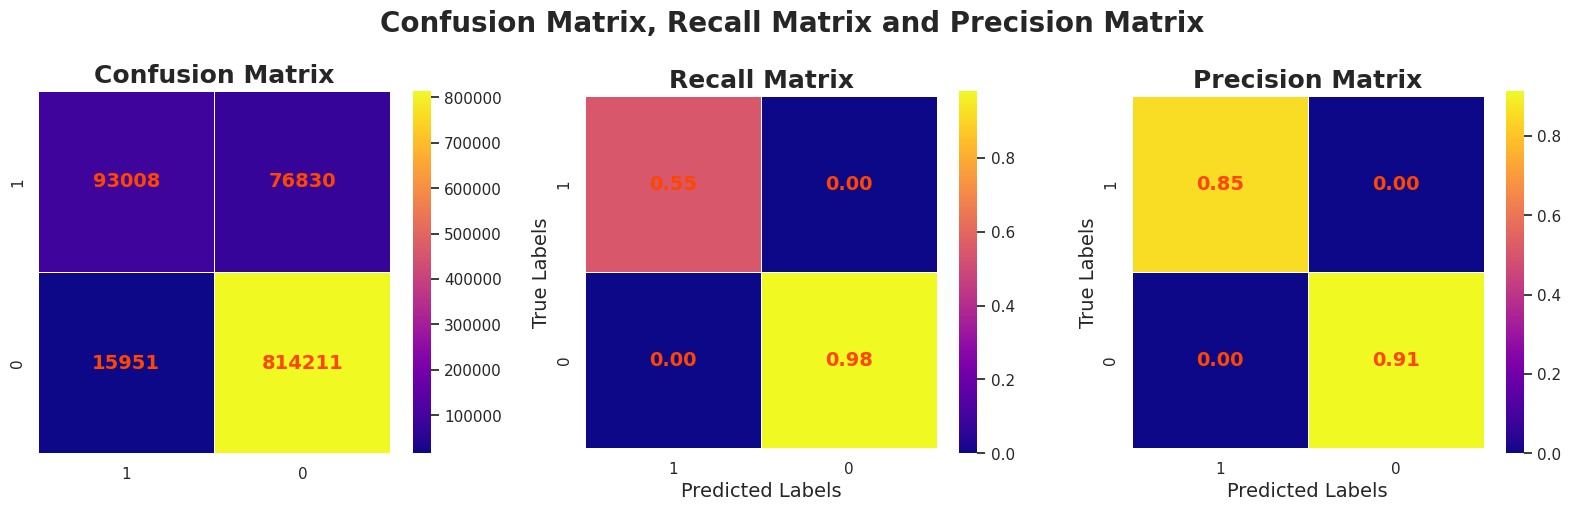

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

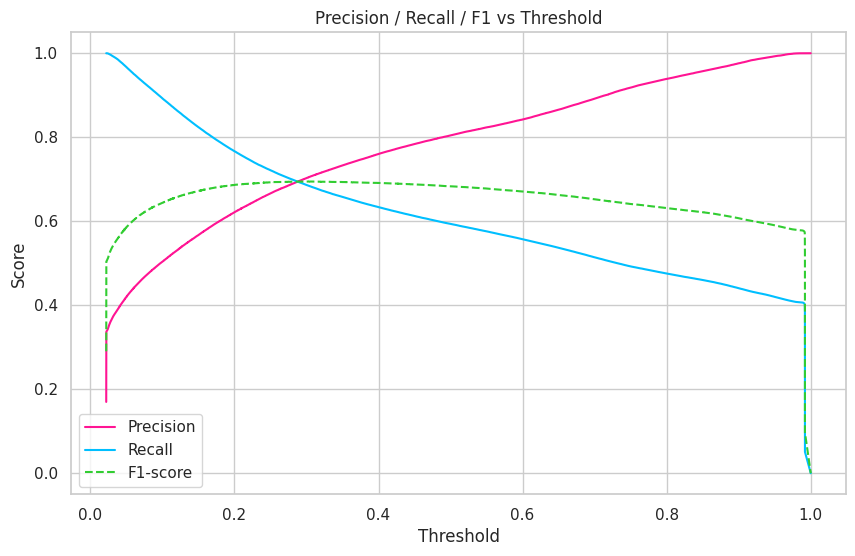

In [ ]:
three_lines_curve(y_test, y_pred_prob)

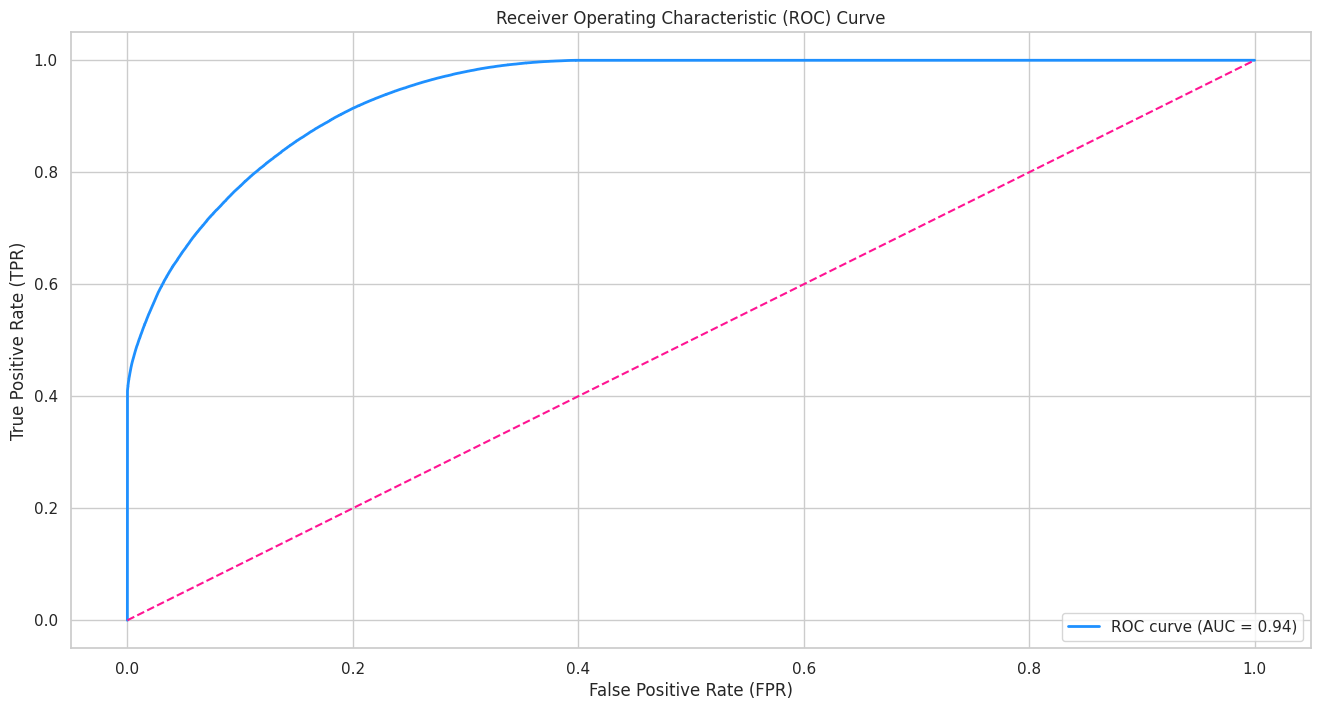

In [ ]:
roc_auc(y_test, y_pred_prob)

#### 6. Support Vector Machine

In [ ]:
%%time
model = LinearSVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

sig_clf = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
sig_clf.fit(X_train, y_train)
y_pred_prob = sig_clf.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.833035
Recall: 0.07442975070361167
Precision: 0.5641037083314739
F1 Score(macro): 0.5195736939141957
F1 Score(weighted): 0.7758228486431817
Log loss: 0.4084770988581972
CPU times: user 38 s, sys: 3.69 s, total: 41.7 s
Wall time: 30.6 s


#### 7. Support Vector Machine Wtih Hyperparameter Tuning

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'loss': ['squared_hinge', 'hinge'],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', {0: 1.0, 1: 5.25}],
    'C': [0.5, 1, 1.5, 2]
}

param_list = list(product(
    param_grid['penalty'],
    param_grid['loss'],
    param_grid['fit_intercept'],
    param_grid['class_weight'],
    param_grid['C']
))

In [ ]:
results = []

for penalty, loss, fit_intercept, class_weight, C in tqdm(param_list):
    params = {
        'penalty': penalty,
        'loss': loss,
        'fit_intercept': fit_intercept,
        'class_weight': class_weight,
        'C': C,
    }

    model = LinearSVC(**params)
    model.fit(X_train, y_train)

    sig_clf = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    sig_clf.fit(X_train, y_train)
    y_pred_prob = sig_clf.predict_proba(X_test)

    log_loss = metrics.log_loss(y_test, y_pred_prob)

    results.append(
        ((penalty, loss, fit_intercept, class_weight, C), log_loss)
    )

    del model, y_pred_prob
    gc.collect()

min_index = min(enumerate(results), key=lambda x: x[1][1])[0]
results[min_index]

 28%|██▊       | 18/64 [05:56<18:33, 24.21s/it]

[2025-04-09 06:52:21.796] [CUML] [warning] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


 33%|███▎      | 21/64 [07:24<20:22, 28.43s/it]

[2025-04-09 06:53:53.067] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-09 06:53:53.067] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


 38%|███▊      | 24/64 [09:29<24:50, 37.26s/it]

[2025-04-09 06:55:54.105] [CUML] [warning] QWL-QN stopped, because the line search failed to advance (step delta = 0.000000)


 75%|███████▌  | 48/64 [17:50<04:10, 15.68s/it]

[2025-04-09 07:04:07.571] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


 86%|████████▌ | 55/64 [20:04<02:44, 18.30s/it]

[2025-04-09 07:06:20.261] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


 92%|█████████▏| 59/64 [21:20<01:35, 19.04s/it]

[2025-04-09 07:07:35.252] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)


100%|██████████| 64/64 [22:54<00:00, 21.48s/it]


(('l1', 'squared_hinge', True, {0: 1.0, 1: 5.25}, 2), 0.39892994193497056)

In [ ]:
%%time
penalty, loss, fit_intercept, class_weight, C = results[min_index][0]
params = {
    'penalty': penalty,
    'loss': loss,
    'fit_intercept': fit_intercept,
    'class_weight': class_weight,
    'C': C
}
model = LinearSVC(**params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

sig_clf = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
sig_clf.fit(X_train, y_train)
y_pred_prob = sig_clf.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

Accuracy: 0.642457
Recall: 0.7465525971808429
Precision: 0.2873228776476293
F1 Score(macro): 0.5787562433570135
F1 Score(weighted): 0.6869235750159015
Log loss: 0.39892994511870955
CPU times: user 21.8 s, sys: 1.79 s, total: 23.6 s
Wall time: 18.2 s


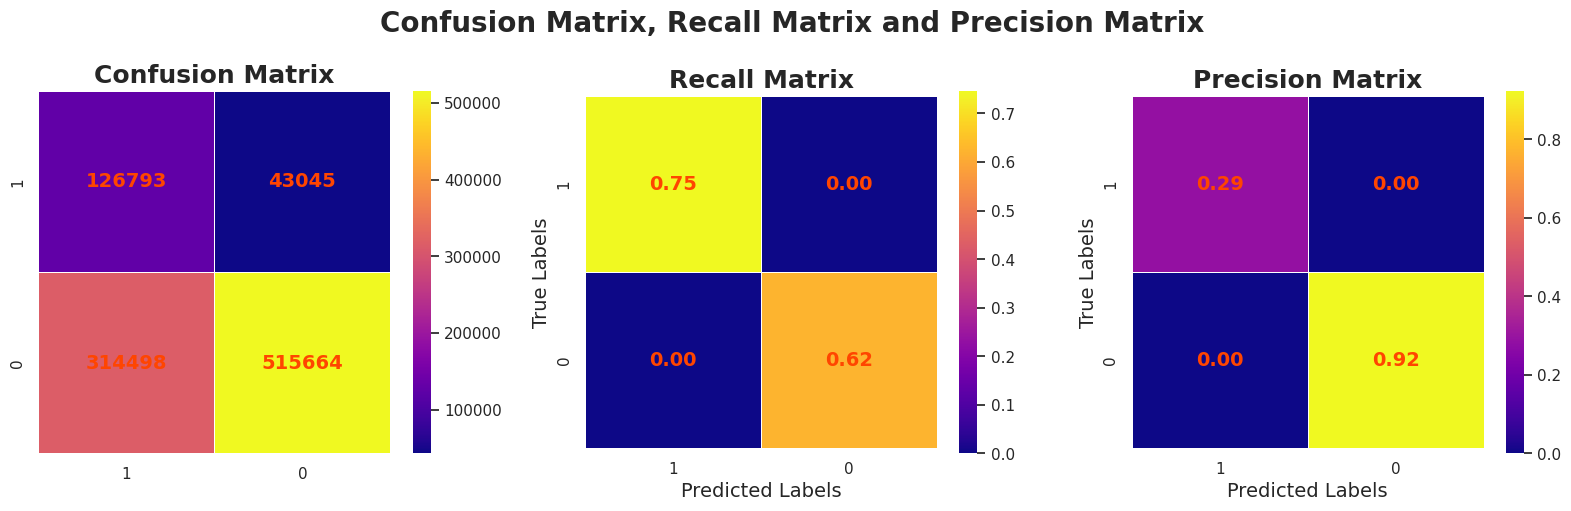

In [ ]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

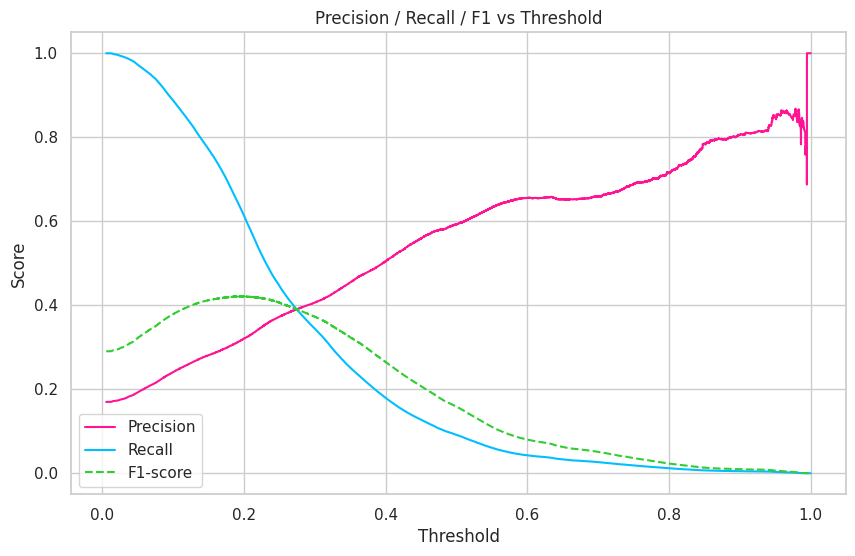

In [ ]:
three_lines_curve(y_test, y_pred_prob)

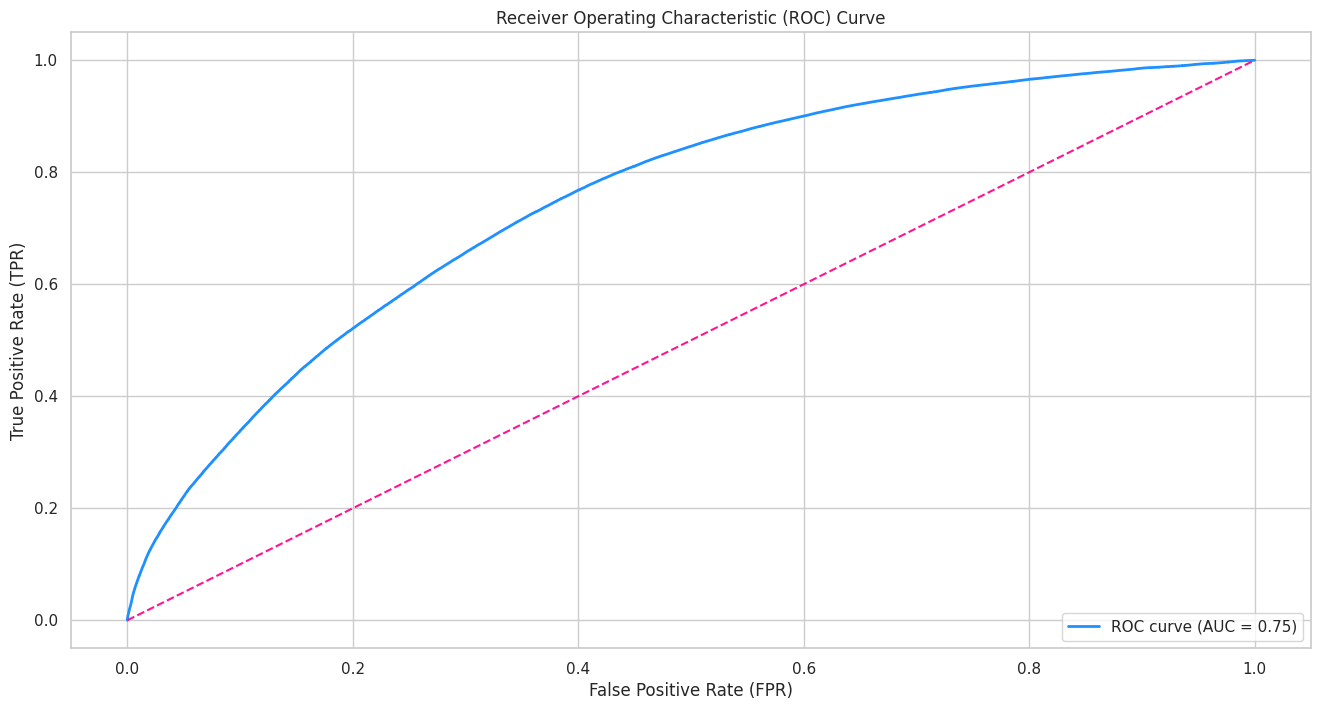

In [ ]:
roc_auc(y_test, y_pred_prob)

#### 8. Catboost Classifier

In [7]:
# import zipfile
# import pandas as pd

# def read_csv_from_zip(zip_path):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         file_names = zip_ref.namelist()
#         # Bỏ qua file rác hệ thống
#         valid_files = [f for f in file_names if f.endswith('.csv') and not f.startswith('__MACOSX')]
#         if len(valid_files) != 1:
#             raise ValueError(f"Expected 1 valid CSV, but found: {valid_files}")
#         with zip_ref.open(valid_files[0]) as f:
#             return pd.read_csv(f).values

# X_train = read_csv_from_zip('/content/drive/MyDrive/X_train.csv.zip')
# y_train = read_csv_from_zip('/content/drive/MyDrive/y_train.csv.zip')
# X_test  = read_csv_from_zip('/content/drive/MyDrive/X_test.csv.zip')
# y_test  = read_csv_from_zip('/content/drive/MyDrive/y_test.csv.zip')

In [ ]:
param_grid = {
    'depth': [6, 8],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [32, 64],
    'random_strength': [1, 5, 10],
    'scale_pos_weight': [1, 2, 5],
}

param_list = list(product(
    param_grid['depth'],
    param_grid['l2_leaf_reg'],
    param_grid['border_count'],
    param_grid['random_strength'],
    param_grid['scale_pos_weight'],
))


results = []

for depth, l2_leaf_reg, border_count, random_strength, scale_pos_weight in tqdm(param_list):
    params = {
        'depth': depth,
        'l2_leaf_reg': l2_leaf_reg,
        'border_count': border_count,
        'scale_pos_weight': scale_pos_weight
    }

    model = CatBoostClassifier(**params, iterations=1000, verbose=0, task_type='GPU', devices='0')
    model.fit(X_train, y_train)

    y_pred_prob = model.predict_proba(X_test)

    log_loss = metrics.log_loss(y_test, y_pred_prob)

    results.append(
        ((depth, l2_leaf_reg, border_count, scale_pos_weight), log_loss)
    )

    del model, y_pred_prob
    gc.collect()

min_index = min(enumerate(results), key=lambda x: x[1][1])[0]
results[min_index]

100%|██████████| 108/108 [1:44:47<00:00, 58.22s/it]


((8, 3, 64, 1), 0.19973123442571697)

In [10]:
%%time
model = CatBoostClassifier(
    depth=8,
    l2_leaf_reg=3,
    border_count=64,
    scale_pos_weight=1,
    iterations=1000,
    verbose=0,
    task_type='GPU',
    devices='0'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

sig_clf = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
sig_clf.fit(X_train, y_train)
y_pred_prob = sig_clf.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Accuracy: 0.907448
Recall: 0.5458377983725669
Precision: 0.8574018238656332
F1 Score(macro): 0.8066428349601347
F1 Score(weighted): 0.8988317300349007
Log loss: 0.22140759774427374
CPU times: user 1min 41s, sys: 33.6 s, total: 2min 15s
Wall time: 1min 36s


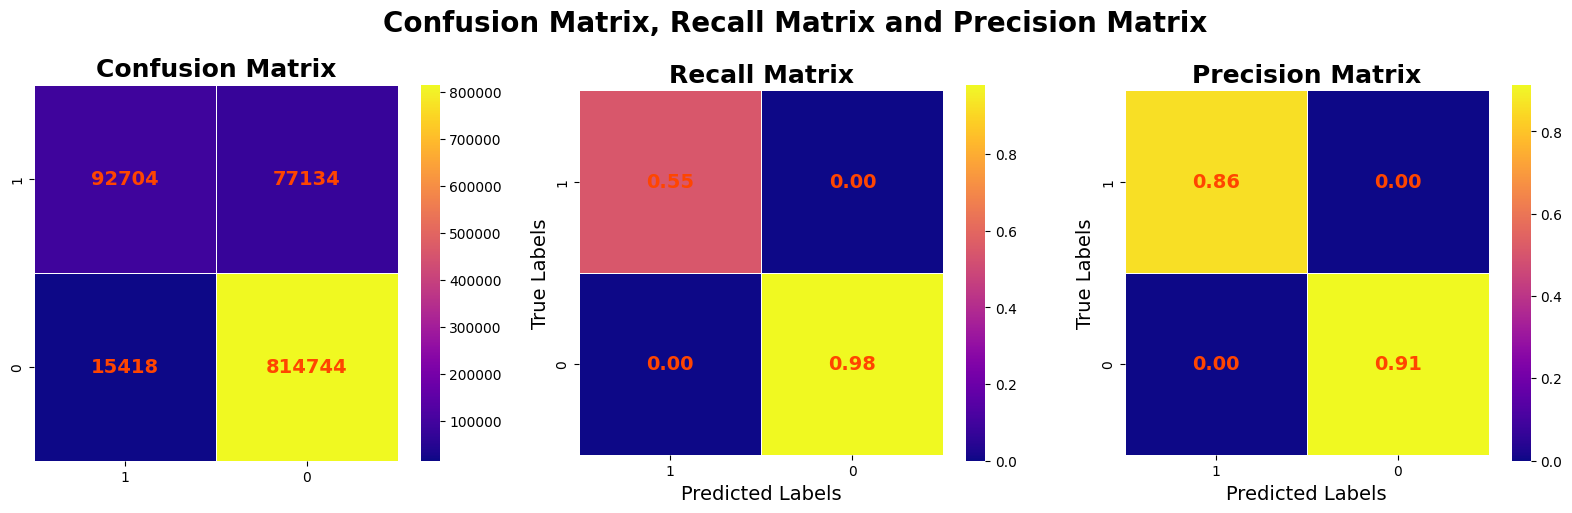

In [11]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


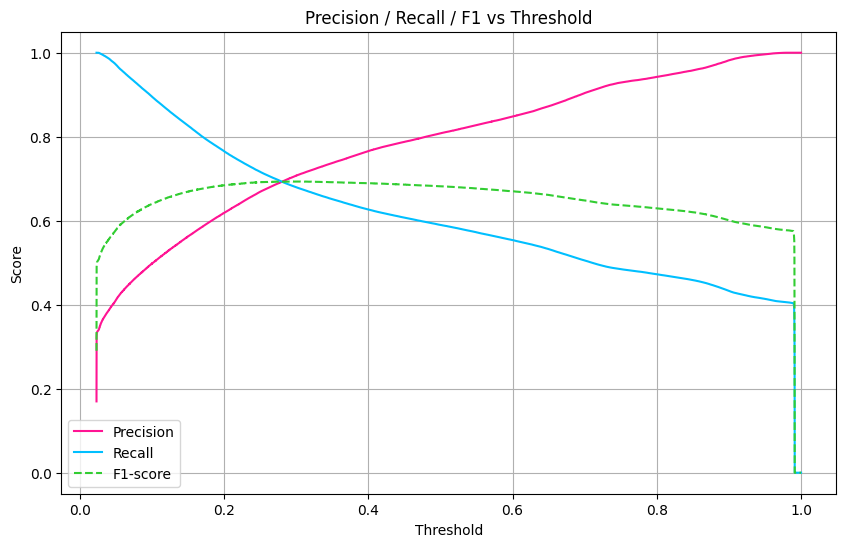

In [12]:
three_lines_curve(y_test, y_pred_prob)

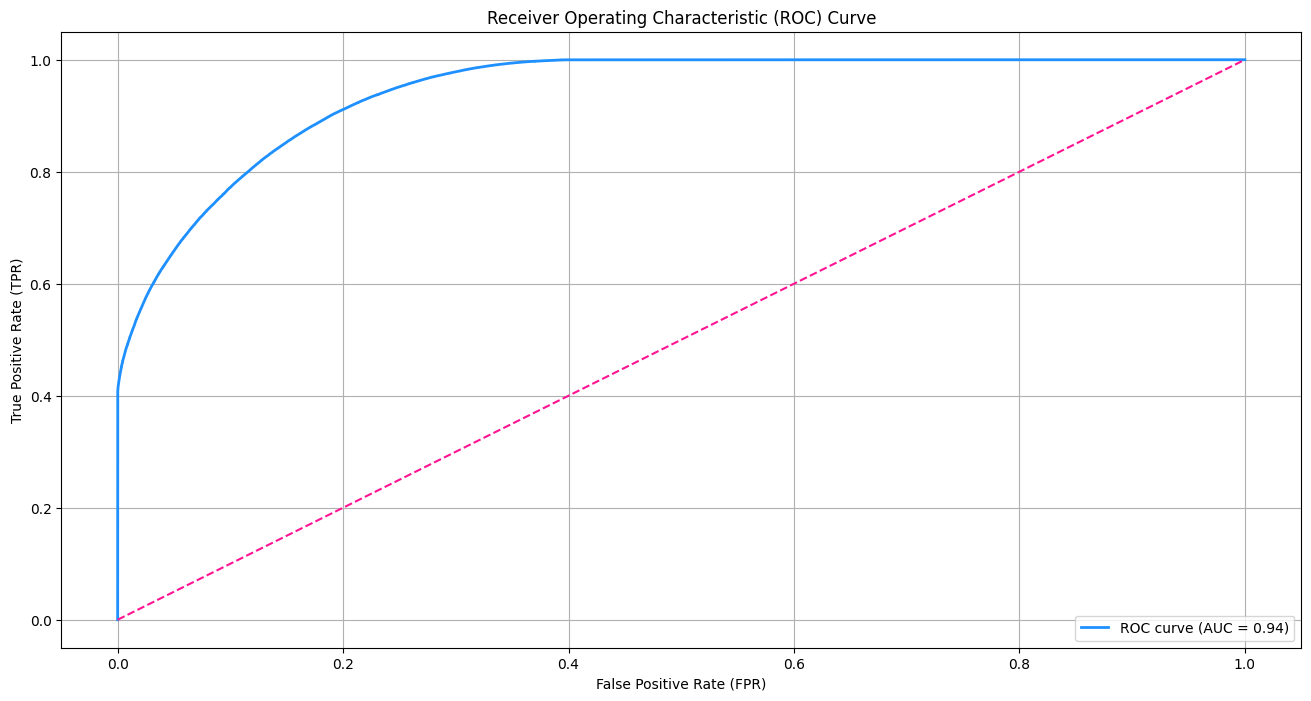

In [13]:
roc_auc(y_test, y_pred_prob)

#### 9. XGBoost Classifier với Hyperparameter Tuning Chi Tiết Hơn

In [ ]:
%time
# 2. XGBoost classifier using GPU
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    device='cuda',
    use_label_encoder=False,
    eval_metric='logloss'
)

# 3. Parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9, 12],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': np.linspace(0, 10, 5),
    'reg_lambda': np.linspace(0, 10, 5),
    'gamma': [0, 0.1, 0.3, 0.5]
}

# 4. Randomized search (now optimizing log loss)
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    scoring='neg_log_loss',
    n_iter=100,
    cv=3,
    verbose=3,
    random_state=42,
    n_jobs=1
)

# 5. Fit
random_search.fit(X_train, y_train)

# 6. Evaluate
y_pred_proba = random_search.predict_proba(X_test)
loss = metrics.log_loss(y_test, y_pred_proba)

print("Best Params:", random_search.best_params_)
print("Log Loss on Test Set:", loss)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [22:45:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=300, reg_alpha=0.0, reg_lambda=5.0, subsample=1.0;, score=-0.199 total time=  28.5s
[CV 2/3] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=300, reg_alpha=0.0, reg_lambda=5.0, subsample=1.0;, score=-0.200 total time=  28.6s
[CV 3/3] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=300, reg_alpha=0.0, reg_lambda=5.0, subsample=1.0;, score=-0.200 total time=  28.7s
[CV 1/3] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=300, reg_alpha=2.5, reg_lambda=0.0, subsample=1.0;, score=-0.209 total time=  29.0s
[CV 2/3] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=12, min_child_weight=1, n_estimators=300, reg_alpha=2.5, reg_lambda=0.0, subsample=1.0;, score=-0.209 total time=  29.7s
[CV 3/3] END colsampl

In [14]:
%%time
model = XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    device='cuda',
    use_label_encoder=False,
    eval_metric='logloss',
    subsample=1.0,
    reg_lambda=2.5,
    reg_alpha=10,
    n_estimators=500,
    min_child_weight=3,
    max_depth=6,
    learning_rate=0.2,
    colsample_bytree=0.6,
    gamma=0.3
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

sig_clf = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
sig_clf.fit(X_train, y_train)
y_pred_prob = sig_clf.predict_proba(X_test)

print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'F1 Score(macro): {metrics.f1_score(y_test, y_pred, average="macro")}')
print(f'F1 Score(weighted): {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'Log loss: {metrics.log_loss(y_test, y_pred_prob)}')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:29:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:29:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  war

Accuracy: 0.907412
Recall: 0.5477337227240076
Precision: 0.8550026653921803
F1 Score(macro): 0.8069634555459897
F1 Score(weighted): 0.8989128076975506
Log loss: 0.22090080791841452
CPU times: user 1min 14s, sys: 1.93 s, total: 1min 16s
Wall time: 1min 2s


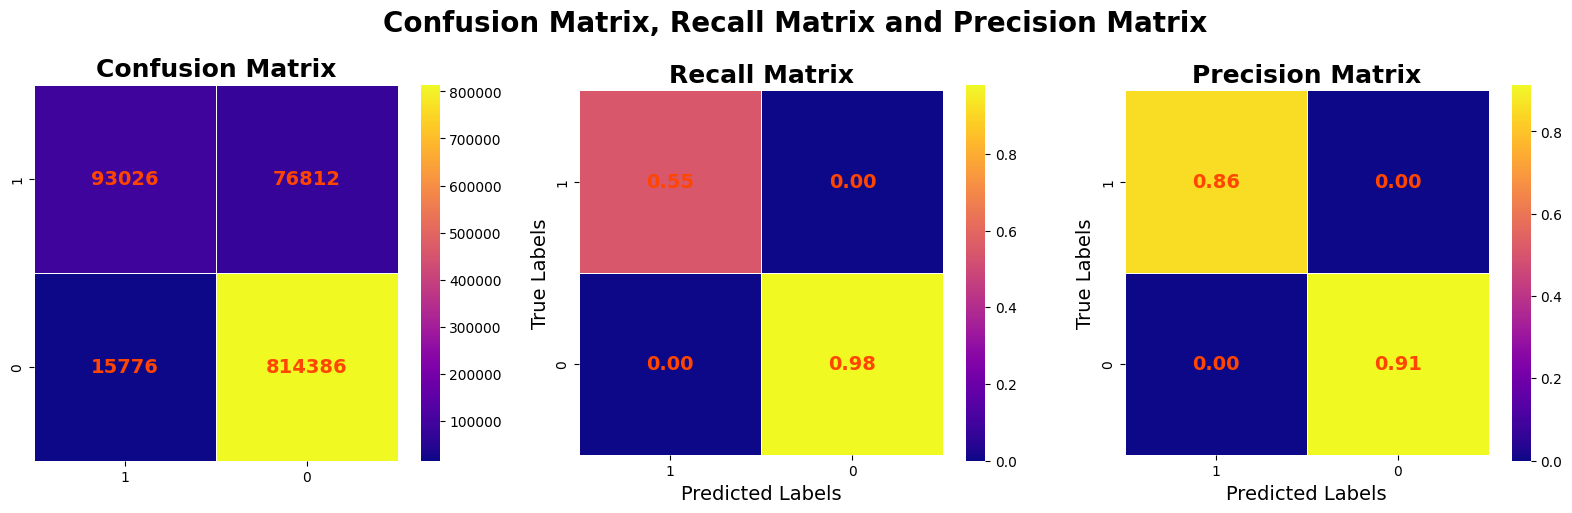

In [15]:
plot_recall_precision_matrices(y_test, y_pred, [1, 0], 'plasma')

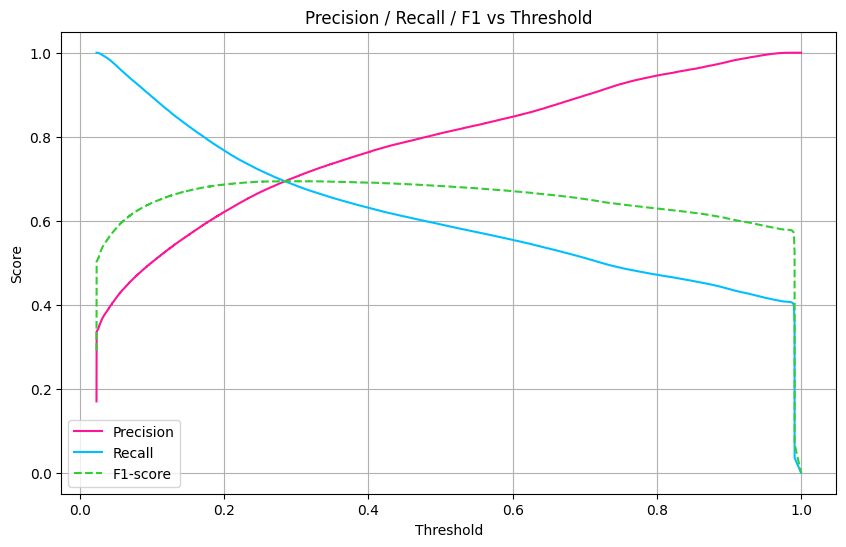

In [16]:
three_lines_curve(y_test, y_pred_prob)

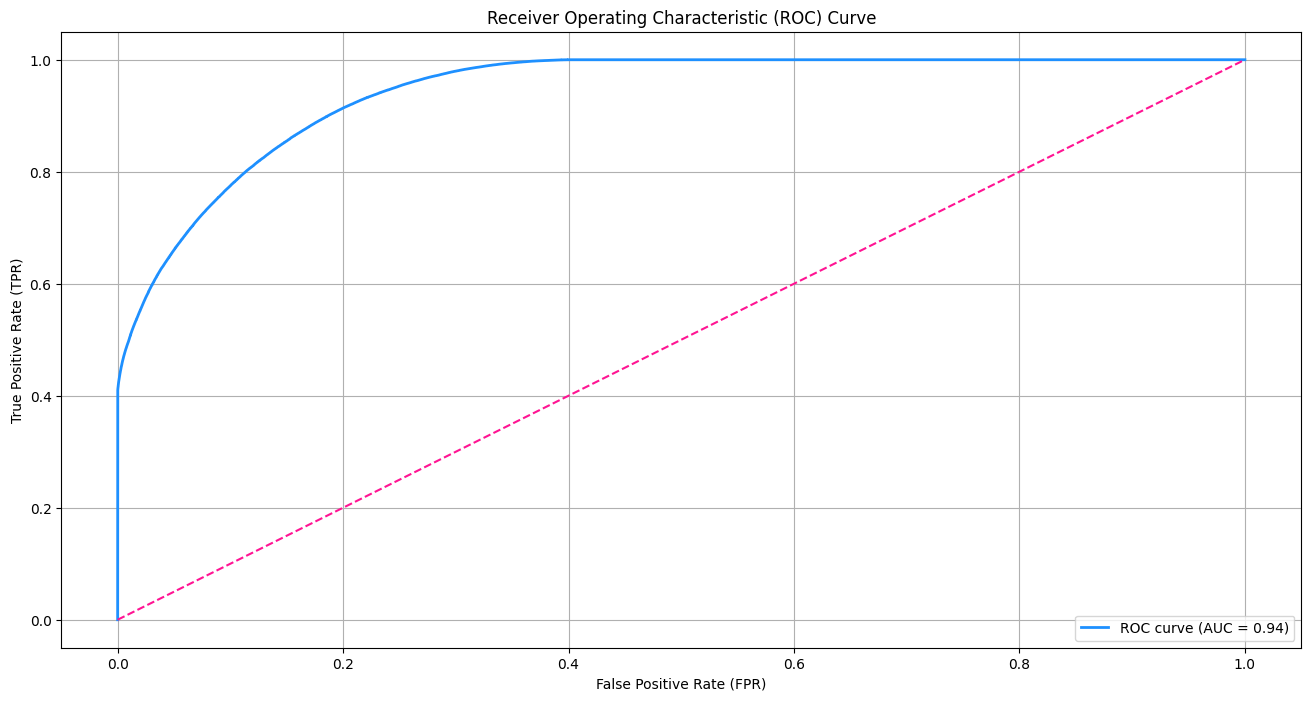

In [17]:
roc_auc(y_test, y_pred_prob)

**Quan sát**: Các mô hình `Random Forest, Catboost và XGBoost` cho hiệu suất vượt trội hơn so với các mô hình như hồi quy `Logistic` hay `Decision Tree Classifier`. Vậy chúng ta sẽ sử dụng 3 mô hình này cho các kỹ thuật `Feature Engineering` đằng sau.

---

### Modeling with Recall Metric